In [1]:
%%capture
!pip3 install python-louvain
!pip3 install cdlib
!pip3 install infomap
!pip3 install wurlitzer
!pip3 install leidenalg
!apt-get install -y graphviz-dev
!pip3 install pygraphviz
!pip install bertopic
!pip install sentence_transformers

In [ ]:
import spacy, sys, os, re, pickle, json, ast
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import copy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager
import matplotlib
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from datetime import datetime
from scipy.spatial import distance
from scipy.stats import wasserstein_distance, entropy

from cdlib import algorithms, viz, evaluation, ensemble, readwrite, TemporalClustering

import community.community_louvain as community_louvain

import gensim.corpora as corpora
from operator import itemgetter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

import bertopic
from sentence_transformers import SentenceTransformer

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/Knowledge Graphs 2022/'
%cd $FOLDER_PATH

/content/drive/.shortcut-targets-by-id/18wZgIc4f2VuuQ34uv_vRrBAOHvMWSEaq/Knowledge Graphs 2022


In [ ]:
all_tweets_df = pd.read_csv("data/all_tweets_50_topics.csv")
all_tweets_df = all_tweets_df.fillna('')
filtered_topic_df = all_tweets_df[(all_tweets_df['topic_keywords'] != '[]') & (all_tweets_df['cleaned_text'] != '')]
filtered_topic_df

id  \
0       1420959115879145474   
2       1420533067400105985   
3       1420373718828679174   
5       1420247492558426112   
6       1419835290160558083   
...                     ...   
923369  1399061982876160006   
923374  1398035919656165376   
923375  1397981081626873863   
923378  1397978637543129088   
923379  1397974671241383944   

                                                     text  \
0       https://t.co/3bM9PoSxS6 #acoustic #orchestra #...   
2                    @kraftoki @MinxMore How do you know?   
3       @MinxMore Also, consider that "immune for only...   
5       https://t.co/tcvJfvwrgH #glitchhop #glitchmusi...   
6                       @MinxMore https://t.co/n2ns5qUVtW   
...                                                   ...   
923369  @graddhybpc For those that don't want to have ...   
923374  Listening to virology today podcast and there ...   
923375                      😂😆😂😂😆 https://t.co/Qc1lwl2lYY   
923378  Wearing a mask alone in your car is like weari...   
923379  @TomiLahren Not to "win".  Just to cover for t...   

                                  time              user_id user_screen_name  \
0       Fri Jul 30 04:07:08 +0000 2021  1404563992907976706         teknoaxe   
2       Wed Jul 28 23:54:10 +0000 2021  1404563992907976706         teknoaxe   
3       Wed Jul 28 13:20:58 +0000 2021  1404563992907976706         teknoaxe   
5       Wed Jul 28 04:59:23 +0000 2021  1404563992907976706         teknoaxe   
6       Tue Jul 27 01:41:27 +0000 2021  1404563992907976706         teknoaxe   
...                                ...                  ...              ...   
923369  Sun May 30 17:55:44 +0000 2021            218741203     mml111mml111   
923374  Thu May 27 21:58:32 +0000 2021            218741203     mml111mml111   
923375  Thu May 27 18:20:37 +0000 2021            218741203     mml111mml111   
923378  Thu May 27 18:10:55 +0000 2021            218741203     mml111mml111   
923379  Thu May 27 17:55:09 +0000 2021            218741203     mml111mml111   

                                             cleaned_text emotion  topic  \
0                                                      []    fear      0   
2                                                ['know']    fear     83   
3       ['also', 'consider', 'immune', 'month', 'come'...    fear      1   
5                                                      []    fear      0   
6                                                      []    fear      0   
...                                                   ...     ...    ...   
923369  ['dont', 'want', 'clinic', 'trip', 'ivermectin...   anger    144   
923374  ['listen', 'virology', 'today', 'podcast', 'wo...     joy     51   
923375                                                 []    fear      0   
923378  ['wear', 'mask', 'alone', 'wear', 'seatbelt', ...    fear     11   
923379         ['cover', 'massive', 'cheating', 'scheme']   anger      2   

        topic_probability                                   raw_cleaned_text  \
0                1.000000                                                      
2                1.000000                                   how do you know?   
3                0.764179  also, consider that immune for only a few mont...   
5                1.000000                                                      
6                1.000000                                                      
...                   ...                                                ...   
923369           1.000000  for those that dont want to have a clinic trip...   
923374           0.535874  listening to virology today podcast and there ...   
923375           1.000000                                                      
923378           1.000000  wearing a mask alone in your car is like weari...   
923379           1.000000  not to win.  just to cover for their massive c...   

                                         cleaned_text_str  \
0                      

### Input Preparation

In [ ]:
# with open('data/all_tweets.pickle', 'rb') as f:
#   all_tweets = pickle.load(f)

In [ ]:
# tweet2interactions = {}
# corrupted_files = []
# entityid2name = {}
# for filename, tweets in tqdm(all_tweets.items(), total=len(all_tweets.items())):
#   try:
#     tweets = tweets[0]
#     for tweet in tweets:
#       id = tweet['id']
#       current_interactions = set()
#       current_interactions.update([x['id'] for x in tweet['entities']['user_mentions']])
#       if tweet['entities']['user_mentions']:
#         for entity in tweet['entities']['user_mentions']:
#           entityid2name[entity['id']] = entity['name']
#       if tweet['in_reply_to_user_id']: current_interactions.add(tweet['in_reply_to_user_id'])
#       current_interactions = list(current_interactions)
#       tweet2interactions[id] = {'id': id, 'interaction': current_interactions}
#   except:
#     corrupted_files.append(filename)

# print(len(corrupted_files))
# print(len(tweet2interactions))

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu May 27 06:09:20 +0000 2021',
 'display_text_range': [14, 22],
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/Fmq6YOsAJq',
    'expanded_url': 'https://twitter.com/mml111mml111/status/1397797047517028353/photo/1',
    'id': 1397797040554446849,
    'id_str': '1397797040554446849',
    'indices': [23, 46],
    'media_url': 'http://pbs.twimg.com/tweet_video_thumb/E2X5AKZXEAE7li4.jpg',
    'media_url_https': 'https://pbs.twimg.com/tweet_video_thumb/E2X5AKZXEAE7li4.jpg',
    'sizes': {'large': {'h': 330, 'resize': 'fit', 'w': 498},
     'medium': {'h': 330, 'resize': 'fit', 'w': 498},
     'small': {'h': 330, 'resize': 'fit', 'w': 498},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/Fmq6YOsAJq'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 2930112702,
    'id_str': '2930112702',
    'indices': [0, 13],
    'name': 'Bob Jackson',
  

In [ ]:
## CHECKPOINT
# with open('social network/entityid2name.pickle', 'wb') as f:
#   pickle.dump(entityid2name, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('social network/entityid2name.pickle', 'rb') as f:
  entityid2name = pickle.load(f)

In [ ]:
# tweets_w_interactions_df = all_tweets_df.merge(pd.DataFrame.from_dict(tweet2interactions.values()))
# ## CHECKPOINT
tweets_w_interactions_df = pd.read_csv("social network/tweets_w_interaction.csv")
tweets_w_interactions_df['interaction'] = tweets_w_interactions_df['interaction'].apply(lambda x: ast.literal_eval(x))
tweets_w_interactions_df

id  \
0       1420959115879145474   
1       1420589578541428739   
2       1420533067400105985   
3       1420373718828679174   
4       1420373378653773829   
...                     ...   
923380  1397974274367963136   
923381  1397972983067693064   
923382  1397972391708475392   
923383  1397813255523995648   
923384  1397797047517028353   

                                                     text  \
0       https://t.co/3bM9PoSxS6 #acoustic #orchestra #...   
1       @DekeSlade Hey Rj!  A link to my youtube chann...   
2                    @kraftoki @MinxMore How do you know?   
3       @MinxMore Also, consider that "immune for only...   
4                     @MinxMore It's like chicken pox....   
...                                                   ...   
923380    @Baklava_in_CA @jordanbpeterson I got my pound.   
923381  @nypost He tries to turn his hotel rooms into ...   
923382  @Baklava_in_CA @jordanbpeterson I've realized ...   
923383  So, what do you think the long term side effec...   
923384     @1st_infantry Bye Bob. https://t.co/Fmq6YOsAJq   

                                  time              user_id user_screen_name  \
0       Fri Jul 30 04:07:08 +0000 2021  1404563992907976706         teknoaxe   
1       Thu Jul 29 03:38:43 +0000 2021  1404563992907976706         teknoaxe   
2       Wed Jul 28 23:54:10 +0000 2021  1404563992907976706         teknoaxe   
3       Wed Jul 28 13:20:58 +0000 2021  1404563992907976706         teknoaxe   
4       Wed Jul 28 13:19:37 +0000 2021  1404563992907976706         teknoaxe   
...                                ...                  ...              ...   
923380  Thu May 27 17:53:34 +0000 2021            218741203     mml111mml111   
923381  Thu May 27 17:48:26 +0000 2021            218741203     mml111mml111   
923382  Thu May 27 17:46:05 +0000 2021            218741203     mml111mml111   
923383  Thu May 27 07:13:44 +0000 2021            218741203     mml111mml111   
923384  Thu May 27 06:09:20 +0000 2021            218741203     mml111mml111   

                                             cleaned_text  emotion  topic  \
0                                                      []     fear      0   
1       ['youtube', 'channel', 'video', 'music', 'feat...      joy     -1   
2                                                ['know']     fear     83   
3       ['also', 'consider', 'immune', 'month', 'come'...     fear      1   
4                                             ['chicken']     fear     -1   
...                                                   ...      ...    ...   
923380                                          ['pound']      joy     -1   
923381               ['turn', 'hotel', 'room', 'vermont']     fear     -1   
923382  ['realize', 'never', 'debt', 'alone', 'interes...  sadness     -1   
923383        ['think', 'long', 'term', 'side', 'effect']     fear     -1   
923384                                                 []      joy     -1   

        topic_probability                                   raw_cleaned_text  \
0                1.000000                                                NaN   
1                0.000000  hey rj!  a link to my youtube channel or the v...   
2                1.000000                                   how do you know?   
3                0.764179  also, consider that immune for only a few mont...   
4                0.000000                           its like chicken pox....   
...                   ...                                                ...   
923380           1.000000                                    i got my pound.   
923381           0.271978     he tries to turn his hotel rooms into vermont?   
923382           0.000000  ive realized we are never going to pay that de...   
923383           0.000000  so, what do you think the long term side effec...   
923384           0.000000                                           bye bob.   

                                         cleaned_text_str  \
0          

In [ ]:
len(set([user for users in tweets_w_interactions_df['interaction'] for user in users]))

271199

In [ ]:
# with open('bot detection/systematic_bot_users.list', 'r') as f:
#   bot_user_list = [int(x) for x in f.read().split('\n')[:-1]]

# bot_tweets_id_list = all_tweets_df[all_tweets_df['user_id'].isin(bot_user_list)].id.tolist()
# tweets_w_interactions_df = tweets_w_interactions_df[~tweets_w_interactions_df['id'].isin(bot_tweets_id_list)]

In [ ]:
tweets_w_interactions_df.index = pd.to_datetime(tweets_w_interactions_df.time, infer_datetime_format=True)
tweets_w_interactions_df = tweets_w_interactions_df.sort_index()
tweets_w_interactions_df = tweets_w_interactions_df.fillna('')
# tweets_w_interactions_df = tweets_w_interactions_df[tweets_w_interactions_df['raw_cleaned_text'] != '']
tweets_w_interactions_df

id  \
time                                             
2009-01-28 00:59:00+00:00           1153845281   
2009-02-05 01:00:40+00:00           1178221904   
2009-02-26 01:18:00+00:00           1251764213   
2009-03-01 00:30:40+00:00           1263823080   
2009-03-08 03:03:29+00:00           1295076660   
...                                        ...   
2021-08-02 22:36:31+00:00  1422325468339097609   
2021-08-02 22:37:03+00:00  1422325602506338332   
2021-08-02 22:37:30+00:00  1422325714821410832   
2021-08-02 22:38:08+00:00  1422325874532274179   
2021-08-02 22:38:37+00:00  1422325997106565120   

                                                                        text  \
time                                                                           
2009-01-28 00:59:00+00:00                       liz, i don't get it.... haha   
2009-02-05 01:00:40+00:00                           i still dont get it.....   
2009-02-26 01:18:00+00:00  @thFOOL film- alamo draft house all day and mu...   
2009-03-01 00:30:40+00:00                                            working   
2009-03-08 03:03:29+00:00                             mtel's today.... yucky   
...                                                                      ...   
2021-08-02 22:36:31+00:00                            https://t.co/DFtBHMZMsc   
2021-08-02 22:37:03+00:00  The world needs answers: When will the Dems ba...   
2021-08-02 22:37:30+00:00  👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻THIS explains it https://t.co/BHhh...   
2021-08-02 22:38:08+00:00               @Murder_Fancier Next level ignorance   
2021-08-02 22:38:37+00:00  This is outrageous. How true is it?\n\nIslam i...   

                                                     time             user_id  \
time                                                                            
2009-01-28 00:59:00+00:00  Wed Jan 28 00:59:00 +0000 2009            18838098   
2009-02-05 01:00:40+00:00  Thu Feb 05 01:00:40 +0000 2009            18838098   
2009-02-26 01:18:00+00:00  Thu Feb 26 01:18:00 +0000 2009            17277830   
2009-03-01 00:30:40+00:00  Sun Mar 01 00:30:40 +0000 2009            22313953   
2009-03-08 03:03:29+00:00  Sun Mar 08 03:03:29 +0000 2009            18838098   
...                                                   ...                 ...   
2021-08-02 22:36:31+00:00  Mon Aug 02 22:36:31 +0000 2021            77244409   
2021-08-02 22:37:03+00:00  Mon Aug 02 22:37:03 +0000 2021           312149882   
2021-08-02 22:37:30+00:00  Mon Aug 02 22:37:30 +0000 2021  879199141271814144   
2021-08-02 22:38:08+00:00  Mon Aug 02 22:38:08 +0000 2021           233374516   
2021-08-02 22:38:37+00:00  Mon Aug 02 22:38:37 +0000 2021          3040416293   

                          user_screen_name  \
time                                         
2009-01-28 00:59:00+00:00     TheMrsBobcat   
2009-02-05 01:00:40+00:00     TheMrsBobcat   
2009-02-26 01:18:00+00:00      soundslike1   
2009-03-01 00:30:40+00:00        jdsmith87   
2009-03-08 03:03:29+00:00     TheMrsBobcat   
...                                    ...   
2021-08-02 22:36:31+00:00      deesbarbara   
2021-08-02 22:37:03+00:00       Chris_1791   
2021-08-02 22:37:30+00:00       Pammyreign   
2021-08-02 22:38:08+00:00  loveletters2007   
2021-08-02 22:38:37+00:00      roygsymonds   

                                                                cleaned_text  \
time                                                                           
2009-01-28 00:59:00+00:00                                   ['dont', 'haha']   
2009-02-05 01:00:40+00:00                                  ['still', 'dont']   
2009-02-26 01:18:00+00:00  ['film', 'alamo', 'draft', 'house', 'music', '...   
2009-03-01 00:30:40+00:00                                           ['work']   
2009-03-08 03:03:29+00:00                        ['mtels', 'today', 'yucky']   
...                                                                      ...   
2021-08-02 22:36:31+00:00                                  

In [ ]:
interaction_counts = Counter([user for users in tweets_w_interactions_df['interaction'] for user in users])
interaction_ids = []
for id, count in interaction_counts.items():
  if count > 10:
    interaction_ids.append(id)

print(len(set(tweets_w_interactions_df['user_id'])))
print(len(interaction_ids))

12246
16034


In [ ]:
start = datetime(2020, 1, 1)
end = datetime(2021, 8, 1)
snapshot_time_points = pd.date_range(start, end, freq="M")
len(snapshot_time_points)

19

### Dynamic Social Network

In [ ]:
# def take_snapshot_social_network(t, temporal_clustering):
#   test = tweets_w_interactions_df.loc[:snapshot_time_points[t]]
#   timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
#   print(f"=====================================================")
#   print(f"...start building user to entity dictionary")
#   user2interactions = dict()
#   for _, row in tqdm(test.iterrows(), total=len(test)):
#     user_id = row['user_id'] 
#     if user_id in user2interactions.keys():
#       user2interactions[user_id].extend(row['interaction'].copy())
#     else:
#       user2interactions[user_id] = row['interaction'].copy()


#   raw_interaction_ids = [id for ids in list(user2interactions.values()) for id in ids]
#   interaction_ids = [x[0] for x in Counter(raw_interaction_ids).items() if x[1] > 10]
#   user_ids = list(user2interactions.keys())
#   n_users = len(user_ids)
#   n_interactions = len(interaction_ids)
#   print(f"number of users: {n_users}")
#   print(f"number of entities: {n_interactions}")
#   print(f"...finished building user to entity dictionary")
#   print(f"=====================================================")
#   print(f"start building social network matrix")
#   social_net_mat = np.zeros((n_users, n_interactions))
#   for i in tqdm(range(n_users), total=n_users):
#     user_interactions = user2interactions[user_ids[i]]
#     for j in range(n_interactions):
#       social_net_mat[i][j] += user_interactions.count(interaction_ids[j])
#   print(f"the shape of social network matrix: {social_net_mat.shape}")
#   print(f"...finished building social network matrix")
#   print(f"=====================================================")
#   print(f"...start saving files")
#   # CHECKPOINT
#   pd.DataFrame(social_net_mat).to_csv(f'social network/snapshots/social_network_matrix/{timestr}.csv', index=False, header=False)
#   # social_net_mat = pd.read_csv('social network/social_net_matrix.csv', header=None).to_numpy()
#   print(f"...files saved")
#   print(f"=====================================================")
#   print(f"...start building graph")
#   nodes = []

#   for i in tqdm(range(n_users), total=n_users):
#     for j in range(n_interactions):
#       if social_net_mat[i, j] > 0:
#         nodes.append([user_ids[i], interaction_ids[j], social_net_mat[i][j]])

#   len(nodes)
#   G = nx.Graph()

#   for pair in nodes:
#       node_x, node_y, weight = pair[0], pair[1], pair[2]
#       if not G.has_node(node_x):
#           G.add_node(node_x)
#       if not G.has_node(node_y):
#           G.add_node(node_y)
#       if not G.has_edge(node_x, node_y) and node_x != node_y:
#           G.add_edge(node_x, node_y, weight=weight)

#   print(nx.info(G))
#   print(f"...finshed building graph")
#   print(f"=====================================================")
#   print(f"...start saving graph")
#   nx.write_gexf(G, f'social network/snapshots/graph/{timestr}.gexf')
#   print(f"...finished saving graph")
#   print(f"=====================================================")
#   print(f"...start community detection")
#   coms = algorithms.endntm(G, [algorithms.louvain(G)])
#   temporal_clustering.add_clustering(coms, t)
#   print(f"..community detection finished")
#   print(f"=====================================================")
#   print(f"...start saving communities")
#   readwrite.write_community_csv(coms, f'social network/snapshots/communities/{timestr}.csv', ",")
#   print(f"...finished saving communities")
#   print()

In [ ]:
# def full_social_network():
#   test = tweets_w_interactions_df
#   print(f"=====================================================")
#   print(f"...start building user to entity dictionary")
#   user2interactions = dict()
#   for _, row in tqdm(test.iterrows(), total=len(test)):
#     user_id = row['user_id'] 
#     if user_id in user2interactions.keys():
#       user2interactions[user_id].extend(row['interaction'].copy())
#     else:
#       user2interactions[user_id] = row['interaction'].copy()


#   raw_interaction_ids = [id for ids in list(user2interactions.values()) for id in ids]
#   interaction_ids = [x[0] for x in Counter(raw_interaction_ids).items() if x[1] > 10]
#   user_ids = list(user2interactions.keys())
#   n_users = len(user_ids)
#   n_interactions = len(interaction_ids)
#   print(f"number of users: {n_users}")
#   print(f"number of entities: {n_interactions}")
#   print(f"...finished building user to entity dictionary")
#   print(f"=====================================================")
#   print(f"start building social network matrix")
#   social_net_mat = np.zeros((n_users, n_interactions))
#   for i in tqdm(range(n_users), total=n_users):
#     user_interactions = user2interactions[user_ids[i]]
#     for j in range(n_interactions):
#       social_net_mat[i][j] += user_interactions.count(interaction_ids[j])
#   print(f"the shape of social network matrix: {social_net_mat.shape}")
#   print(f"...finished building social network matrix")
#   print(f"=====================================================")
#   print(f"...start saving files")
#   # CHECKPOINT
#   pd.DataFrame(social_net_mat).to_csv(f'social network/snapshots/social_network_matrix/full.csv', index=False, header=False)
#   # social_net_mat = pd.read_csv('social network/social_net_matrix.csv', header=None).to_numpy()
#   print(f"...files saved")
#   print(f"=====================================================")
#   print(f"...start building graph")
#   nodes = []

#   for i in tqdm(range(n_users), total=n_users):
#     for j in range(n_interactions):
#       if social_net_mat[i, j] > 0:
#         nodes.append([user_ids[i], interaction_ids[j], social_net_mat[i][j]])

#   len(nodes)
#   G = nx.Graph()

#   for pair in nodes:
#       node_x, node_y, weight = pair[0], pair[1], pair[2]
#       if not G.has_node(node_x):
#           G.add_node(node_x)
#       if not G.has_node(node_y):
#           G.add_node(node_y)
#       if not G.has_edge(node_x, node_y) and node_x != node_y:
#           G.add_edge(node_x, node_y, weight=weight)

#   print(nx.info(G))
#   print(f"...finshed building graph")
#   print(f"=====================================================")
#   print(f"...start saving graph")
#   nx.write_gexf(G, f'social network/snapshots/graph/full.gexf')
#   print(f"...finished saving graph")

In [ ]:
# full_social_network()

...start building user to entity dictionary


100%|██████████| 923385/923385 [00:51<00:00, 17941.51it/s]


number of users: 12246
number of entities: 16034
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 12246/12246 [08:49<00:00, 23.12it/s]


the shape of social network matrix: (12246, 16034)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 12246/12246 [01:21<00:00, 150.56it/s]


Graph with 26064 nodes and 294773 edges
...finshed building graph
...start saving graph
...finished saving graph


In [ ]:
# tc = TemporalClustering()
# for t in range(0, 10):
#   take_snapshot_social_network(t, tc)

...start building user to entity dictionary


100%|██████████| 177751/177751 [00:08<00:00, 20840.81it/s]


number of users: 2559
number of entities: 3152
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 2559/2559 [00:17<00:00, 149.45it/s]


the shape of social network matrix: (2559, 3152)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 2559/2559 [00:02<00:00, 971.58it/s]


Graph with 5255 nodes and 47865 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 183289/183289 [00:08<00:00, 20842.12it/s]


number of users: 2654
number of entities: 3263
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 2654/2654 [00:18<00:00, 143.78it/s]


the shape of social network matrix: (2654, 3263)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 2654/2654 [00:02<00:00, 935.94it/s]


Graph with 5448 nodes and 49457 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 189871/189871 [00:09<00:00, 20837.06it/s]


number of users: 2745
number of entities: 3360
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 2745/2745 [00:19<00:00, 140.56it/s]


the shape of social network matrix: (2745, 3360)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 2745/2745 [00:03<00:00, 913.88it/s]


Graph with 5631 nodes and 51299 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 197543/197543 [00:09<00:00, 20659.06it/s]


number of users: 2840
number of entities: 3481
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 2840/2840 [00:20<00:00, 136.30it/s]


the shape of social network matrix: (2840, 3481)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 2840/2840 [00:03<00:00, 882.23it/s]


Graph with 5847 nodes and 53465 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 206570/206570 [00:09<00:00, 20772.49it/s]


number of users: 2957
number of entities: 3607
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 2957/2957 [00:22<00:00, 129.57it/s]


the shape of social network matrix: (2957, 3607)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 2957/2957 [00:03<00:00, 852.46it/s]


Graph with 6078 nodes and 56017 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 217419/217419 [00:10<00:00, 20398.41it/s]


number of users: 3097
number of entities: 3757
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 3097/3097 [00:24<00:00, 125.98it/s]


the shape of social network matrix: (3097, 3757)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 3097/3097 [00:03<00:00, 815.55it/s]


Graph with 6347 nodes and 58762 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 227295/227295 [00:11<00:00, 20627.54it/s]


number of users: 3233
number of entities: 3906
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 3233/3233 [00:26<00:00, 120.33it/s]


the shape of social network matrix: (3233, 3906)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 3233/3233 [00:04<00:00, 786.06it/s]


Graph with 6624 nodes and 61679 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 236609/236609 [00:11<00:00, 20746.17it/s]


number of users: 3366
number of entities: 4036
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 3366/3366 [00:28<00:00, 117.13it/s]


the shape of social network matrix: (3366, 4036)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 3366/3366 [00:04<00:00, 756.28it/s]


Graph with 6862 nodes and 64461 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 247413/247413 [00:12<00:00, 20403.69it/s]


number of users: 3515
number of entities: 4223
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 3515/3515 [00:31<00:00, 111.30it/s]


the shape of social network matrix: (3515, 4223)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 3515/3515 [00:04<00:00, 729.25it/s]


Graph with 7183 nodes and 67692 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 263865/263865 [00:12<00:00, 20760.63it/s]


number of users: 3766
number of entities: 4506
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 3766/3766 [00:35<00:00, 105.22it/s]


the shape of social network matrix: (3766, 4506)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 3766/3766 [00:05<00:00, 683.41it/s]


Graph with 7695 nodes and 73225 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities



In [ ]:
# for t in range(10, 12):
#   take_snapshot_social_network(t, tc)

...start building user to entity dictionary


100%|██████████| 288946/288946 [00:26<00:00, 10753.03it/s]


number of users: 4118
number of entities: 4771
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 4118/4118 [00:41<00:00, 99.27it/s] 


the shape of social network matrix: (4118, 4771)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 4118/4118 [00:06<00:00, 646.83it/s]


Graph with 8252 nodes and 81553 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 310263/310263 [00:14<00:00, 20687.75it/s]


number of users: 4441
number of entities: 5085
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 4441/4441 [00:47<00:00, 93.33it/s] 


the shape of social network matrix: (4441, 5085)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 4441/4441 [00:07<00:00, 596.94it/s]


Graph with 8853 nodes and 88706 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities



In [ ]:
# for t in range(12, 19):
#   take_snapshot_social_network(t, tc)

...start building user to entity dictionary


100%|██████████| 353720/353720 [00:17<00:00, 20668.32it/s]


number of users: 5096
number of entities: 5603
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 5096/5096 [00:59<00:00, 85.71it/s] 


the shape of social network matrix: (5096, 5603)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 5096/5096 [00:09<00:00, 542.13it/s]


Graph with 9950 nodes and 106064 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 380375/380375 [00:18<00:00, 20701.22it/s]


number of users: 5485
number of entities: 5991
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 5485/5485 [01:08<00:00, 80.46it/s] 


the shape of social network matrix: (5485, 5991)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 5485/5485 [00:10<00:00, 505.18it/s]


Graph with 10658 nodes and 115035 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 408929/408929 [00:19<00:00, 20734.88it/s]


number of users: 5868
number of entities: 6400
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 5868/5868 [01:18<00:00, 75.18it/s] 


the shape of social network matrix: (5868, 6400)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 5868/5868 [00:12<00:00, 474.01it/s]


Graph with 11405 nodes and 122973 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 444862/444862 [00:21<00:00, 20494.46it/s]


number of users: 6310
number of entities: 7128
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 6310/6310 [01:34<00:00, 66.83it/s] 


the shape of social network matrix: (6310, 7128)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 6310/6310 [00:14<00:00, 426.70it/s]


Graph with 12517 nodes and 133813 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 498400/498400 [00:24<00:00, 20751.70it/s]


number of users: 6972
number of entities: 7973
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 6972/6972 [01:57<00:00, 59.29it/s] 


the shape of social network matrix: (6972, 7973)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 6972/6972 [00:18<00:00, 379.45it/s]


Graph with 13917 nodes and 149270 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 601334/601334 [00:29<00:00, 20423.52it/s]


number of users: 8251
number of entities: 9596
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 8251/8251 [02:47<00:00, 49.31it/s] 


the shape of social network matrix: (8251, 9596)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 8251/8251 [00:26<00:00, 316.66it/s]


Graph with 16671 nodes and 181241 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities

...start building user to entity dictionary


100%|██████████| 907645/907645 [00:57<00:00, 15751.14it/s]


number of users: 11409
number of entities: 15798
...finished building user to entity dictionary
start building social network matrix


100%|██████████| 11409/11409 [07:02<00:00, 26.98it/s]


the shape of social network matrix: (11409, 15798)
...finished building social network matrix
...start saving files
...files saved
...start building graph


100%|██████████| 11409/11409 [00:59<00:00, 191.83it/s]


Graph with 25457 nodes and 291412 edges
...finshed building graph
...start saving graph
...finished saving graph
...start community detection
..community detection finished
...start saving communities
...finished saving communities



### Network Analysis

In [ ]:
tc = TemporalClustering()
for t in range(len(snapshot_time_points)):
  timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
  comm = readwrite.read_community_csv(f"social network/snapshots/communities/louvain/{timestr}.csv")
  tc.add_clustering(comm, t)

In [ ]:
jaccard = lambda x, y:  len(set(x) & set(y)) / len(set(x) | set(y))
matches = tc.community_matching(jaccard, two_sided=True)

In [ ]:
## CHECKPOINT
# with open("social network/dynamic_comm_detect_matches.pickle", "wb") as f:
#   pickle.dump(matches, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open("social network/dynamic_comm_detect_tc.json", "w") as f:
#   json.dump(tc.to_json(), f)

In [ ]:
lifecycle_polytree = tc.lifecycle_polytree(jaccard, two_sided=True)
print(nx.info(lifecycle_polytree))
## CHECKPOINT
# nx.write_gexf(lifecycle_polytree, "social network/lifecycle_polytree.gexf")

DiGraph with 2411 nodes and 25657 edges


In [ ]:
top_comms_evolution = {}

for cid in range(20):
  current_cid = cid
  current_comm_evolution = []
  for t in range(len(snapshot_time_points)-1):
    current_comm = f"{t}_{current_cid}"
    possible_matches = [match for match in matches if match[0] == current_comm]
    sorted_matches = sorted(possible_matches, key=lambda x: x[2], reverse=True)
    top_pro_match = sorted_matches[0]
    if sorted_matches[0][2] > 0.1:
      current_comm_evolution.append(top_pro_match)
      current_cid = int(top_pro_match[1].split('_')[1])
    else:
      break
  top_comms_evolution[cid] = current_comm_evolution

top_comms_evolution

{0: [('0_0', '1_0', 0.8034398034398035),
  ('1_0', '2_0', 0.655266226195103),
  ('2_0', '3_0', 0.8011338857392063),
  ('3_0', '4_0', 0.6475109809663251),
  ('4_0', '5_0', 0.7898042113040266),
  ('5_0', '6_0', 0.8119249171880751),
  ('6_0', '7_0', 0.8256649892163911),
  ('7_0', '8_0', 0.8093249826026444),
  ('8_0', '9_0', 0.6986899563318777),
  ('9_0', '10_0', 0.6121318168562263),
  ('10_0', '11_0', 0.5927641099855282),
  ('11_0', '12_0', 0.5769841269841269),
  ('12_0', '13_0', 0.689225771521386),
  ('13_0', '14_0', 0.7724896836313617),
  ('14_0', '15_0', 0.45148219236510984),
  ('15_0', '16_1', 0.6277322404371585),
  ('16_1', '17_0', 0.7476593847525635),
  ('17_0', '18_0', 0.6431649715566282)],
 1: [('0_1', '1_1', 0.748730964467005),
  ('1_1', '2_1', 0.25842696629213485),
  ('2_1', '3_1', 0.6745956232159848),
  ('3_1', '4_2', 0.31877729257641924),
  ('4_2', '5_1', 0.5811051693404634),
  ('5_1', '6_1', 0.7038269550748752),
  ('6_1', '7_2', 0.7969639468690702),
  ('7_2', '8_1', 0.6005509

In [ ]:
top_comm_edges = [edge for edges in top_comms_evolution.values() for edge in edges]
G = nx.DiGraph()
G.add_weighted_edges_from(top_comm_edges)
print(nx.info(G))

comms_tc = json.loads(tc.to_json())["clusters"]
comm_sizes = {}
comm_times = {}
for t in range(len(comms_tc)):
  for id, community in comms_tc[t]["communities"].items():
    comm_sizes[id] = len(community)
    comm_times[id] = t


sub_lifecycle = lifecycle_polytree.subgraph((n for n in lifecycle_polytree.nodes() if comm_sizes[n] > 100))
print(nx.info(sub_lifecycle))
comm_lifecycle_tree = nx.DiGraph((source, target, attr) for source, target, attr in sub_lifecycle.edges(data=True) if attr['weight'] > 0.3)
print(nx.info(comm_lifecycle_tree))

DiGraph with 297 nodes and 282 edges
DiGraph with 289 nodes and 244 edges
DiGraph with 223 nodes and 190 edges


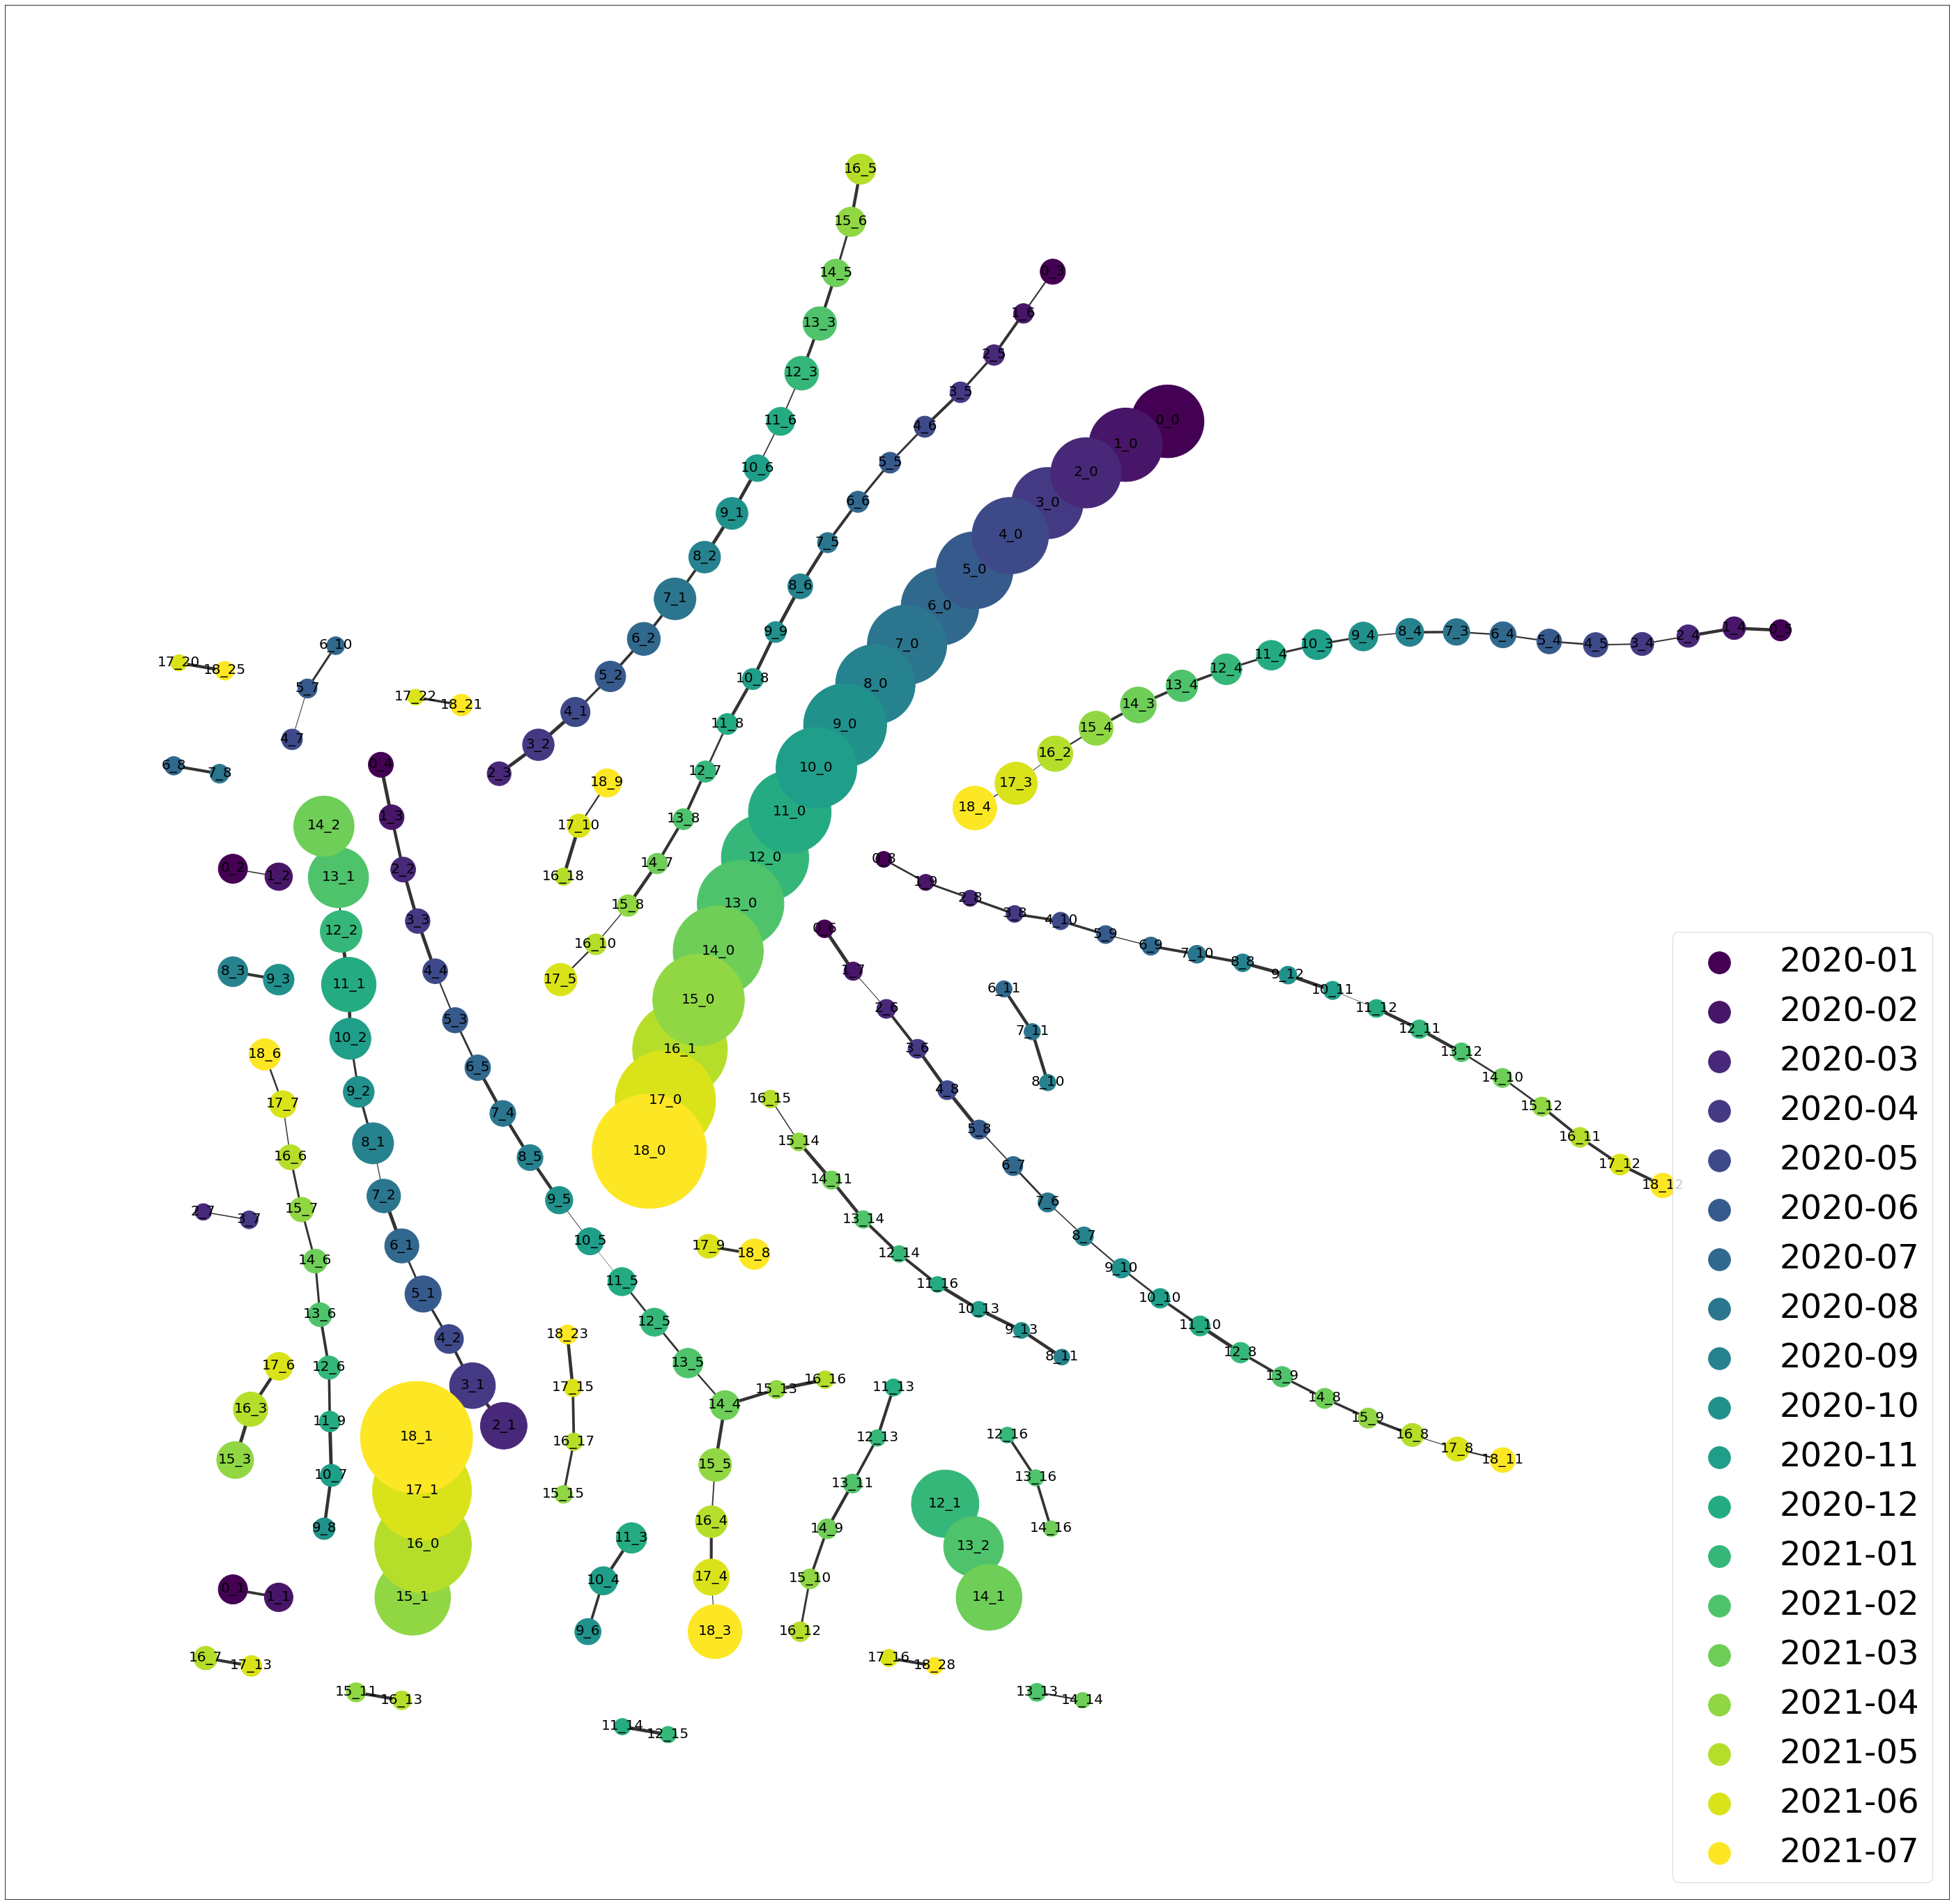

In [ ]:
plt.figure(figsize=(50, 50))
pos = graphviz_layout(comm_lifecycle_tree)

node_size = [comm_sizes[n]*5 for n in comm_lifecycle_tree.nodes()]
width = [e[2]['weight']*5 for e in G.edges(data=True)]
node_color = [comm_times[n] for n in comm_lifecycle_tree.nodes()]
maxval = np.max(node_color)
node_color = np.array(node_color) / maxval
cmap = cm.get_cmap('viridis')

nx.draw_networkx_nodes(comm_lifecycle_tree, pos, node_size=node_size, cmap=cmap, node_color=node_color)
nx.draw_networkx_labels(comm_lifecycle_tree, pos, font_size=20)
nx.draw_networkx_edges(comm_lifecycle_tree, pos, width=width, arrows=False, alpha=0.8)

time_labels = [time.strftime('%Y-%m') for time in snapshot_time_points]

for v in set(comm_times.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label=f'{time_labels[v]}', s=1000)

plt.legend(fontsize=48)
plt.show()

# nx.is_forest(G)

In [ ]:
# comm_nodes = comm_sorted_users[0]

# node_prob = dict()

# for comm, nodes in comm_nodes:
#   time = int(comm.split('_')[0])
#   for node, prob in nodes:
#     if node not in node_prob.keys():
#       node_prob[node] = [(0, 0)]*len(snapshot_time_points)
#     accum_p, times = node_prob[node][time]
#     node_prob[node][time] = (prob+accum_p, times+1)


# node_central_score = dict()
# for node in node_prob:
#   node_scores = np.zeros(len(snapshot_time_points))
#   for i in range(len(snapshot_time_points)):
#     if node_prob[node][i][1]:
#       node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
#     else:
#       node_scores[i] = 0
#   node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

# sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
# sorted_nodes = [node for node, _ in sorted_node_prob]
# central_nodes = sorted_nodes[:10]


# un_directed_G = comm_lifecycle_tree.to_undirected()
# S = [un_directed_G.subgraph(c).copy() for c in nx.connected_components(un_directed_G)]
# top_com = sorted(S[1].nodes(), key=lambda x: int(x.split('_')[0]))

# central_node_centrality = []
# previous = 0
# for com in top_com:
#   t, cid = com.split('_')
#   t, cid = int(t), int(cid)
#   timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
#   G = nx.read_gexf(f"social network/snapshots/graph/{timestr}.gexf")
#   comm = readwrite.read_community_csv(f"social network/snapshots/communities/louvain/{timestr}.csv")
#   comm_G = G.subgraph(comm.communities[cid]).copy()
#   current = G.degree(central_nodes[0], weight='weight')
#   central_node_centrality.append(current-previous)
#   previous = current

# plt.figure(figsize=(8, 6))
# plt.plot(snapshot_time_points[1:], central_node_centrality[1:], '--o')
# plt.xlabel('time')
# plt.ylabel('# of new mentions')

In [ ]:
# time_2_sorted_comm = dict()

# for t in tqdm(range(len(snapshot_time_points)), total=len(snapshot_time_points)):
#   timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
#   G = nx.read_gexf(f"social network/snapshots/graph/{timestr}.gexf")
#   coms = readwrite.read_community_csv(f"social network/snapshots/communities/{timestr}.csv")
#   time_2_sorted_comm[t] = dict()
#   for cid, community in tqdm(enumerate(coms.communities), total=len(coms.communities)):
#     subG = G.subgraph(community)
#     close_central = nx.closeness_centrality(subG)
#     sorted_close_central = sorted(close_central.items(), key=lambda x: x[1], reverse=True)
#     time_2_sorted_comm[t][f"{t}_{cid}"] = sorted_close_central
#   with open("social network/sorted_closeness_central_nodes.pickle", "wb") as f:
#     pickle.dump(time_2_sorted_comm, f, protocol=pickle.HIGHEST_PROTOCOL)

# # CHECKPOINT
# with open("social network/sorted_closeness_central_nodes.pickle", "wb") as f:
#   pickle.dump(time_2_sorted_comm, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open("social network/sorted_closeness_central_nodes.pickle", "rb") as f:
#   test = pickle.load(f)

# print(test == time_2_sorted_comm)

100%|██████████| 19/19 [9:00:36<00:00, 1707.16s/it]


True


In [ ]:
with open("social network/louvain_sorted_closeness_central_nodes.pickle", "rb") as f:
  time_2_sorted_comm = pickle.load(f)

In [ ]:
undirected_comm_lifecycle_tree = comm_lifecycle_tree.to_undirected()
S = [undirected_comm_lifecycle_tree.subgraph(c).copy() for c in nx.connected_components(undirected_comm_lifecycle_tree)]

comm_sorted_users = []
for s in S:
  nodes = sorted(s.nodes(), key=lambda x: int(x.split('_')[0]))
  sorted_users = []
  for node in nodes:
    sorted_users.append((node, time_2_sorted_comm[int(node.split('_')[0])][node]))
  comm_sorted_users.append(sorted_users)

In [ ]:
def comm_raw_count(comm):
  return len([user for _, users in comm for user in users])

comm_sorted_users = sorted(comm_sorted_users, key=lambda x: comm_raw_count(x), reverse=True)

In [ ]:
# central_nodes = []
# for comm in comm_sorted_users:
#   central_nodes.append(sorted(Counter([users[0][0] for _, users in comm]).items(), key=lambda x: x[1], reverse=True)[0])

# central_nodes = [node for node, freq in central_nodes if freq > 10]

node_prob = dict()

for comm, nodes in comm_sorted_users[0]:
  time = int(comm.split('_')[0])
  for node, prob in nodes:
    if node not in node_prob.keys():
      node_prob[node] = [(0, 0)]*len(snapshot_time_points)
    accum_p, times = node_prob[node][time]
    node_prob[node][time] = (prob+accum_p, times+1)


node_central_score = dict()
for node in node_prob:
  node_scores = np.zeros(len(snapshot_time_points))
  for i in range(len(snapshot_time_points)):
    if node_prob[node][i][1]:
      node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
    else:
      node_scores[i] = 0
  node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
sorted_nodes = [node for node, _ in sorted_node_prob]
central_nodes = sorted_nodes[:10]
central_nodes


all_tweets_df[all_tweets_df['user_id'].isin([int(x) for x in sorted_nodes])]

id  \
170     1320048130428178434   
171     1320047775820713986   
172     1320047050805989384   
173     1318936759619719169   
174     1312746786382131201   
...                     ...   
923045  1029407571537321984   
923046  1029203493532327936   
923047  1029203326003425281   
923048  1029202814336024577   
923049  1029201335810314244   

                                                     text  \
170     @JohnBrennan Lying ass you who conspired to ki...   
171                      @BarackObama Stop lying traitor.   
172                               https://t.co/W9IIA4lYfW   
173                               https://t.co/i8YVal9P9B   
174     @BarackObama Jigga you could give less than tw...   
...                                                   ...   
923045  @NicoleKidman https://t.co/ixakQEj17R\n\nEvil ...   
923046  @JudyPrincz @resist207 @AndrewSolender @Barack...   
923047  @JudyPrincz @resist207 @AndrewSolender @Barack...   
923048  @BarackObama Why do you live a LIE?  You are m...   
923049  @angelurena @BillClinton @ClintonGlobal Hide y...   

                                  time     user_id user_screen_name  \
170     Sat Oct 24 17:02:54 +0000 2020   371356914         AyeAmAye   
171     Sat Oct 24 17:01:29 +0000 2020   371356914         AyeAmAye   
172     Sat Oct 24 16:58:36 +0000 2020   371356914         AyeAmAye   
173     Wed Oct 21 15:26:42 +0000 2020   371356914         AyeAmAye   
174     Sun Oct 04 13:29:58 +0000 2020   371356914         AyeAmAye   
...                                ...         ...              ...   
923045  Tue Aug 14 16:41:05 +0000 2018  4862259560      TM_GilbertR   
923046  Tue Aug 14 03:10:09 +0000 2018  4862259560      TM_GilbertR   
923047  Tue Aug 14 03:09:29 +0000 2018  4862259560      TM_GilbertR   
923048  Tue Aug 14 03:07:27 +0000 2018  4862259560      TM_GilbertR   
923049  Tue Aug 14 03:01:34 +0000 2018  4862259560      TM_GilbertR   

                                             cleaned_text emotion  topic  \
170                                  ['conspire', 'kill']   anger     -1   
171                          ['stop', 'lying', 'traitor']   anger     -1   
172                                                    []    fear      0   
173                                                    []    fear      0   
174                    ['jigga', 'could', 'give', 'less']   anger     98   
...                                                   ...     ...    ...   
923045                          ['evil', 'never', 'know']   anger     -1   
923046                                                 []    fear      0   
923047                                                 []    fear      0   
923048  ['live', 'marry', 'tran', 'kiddy', 'diddler', ...   anger     13   
923049                                  ['hide', 'child']    fear     71   

        topic_probability                                   raw_cleaned_text  \
170              0.000000  lying ass you who conspired to kill him. fuck ...   
171              0.000000                                stop lying traitor.   
172              1.000000                                                      
173              1.000000                                                      
174              0.205556           jigga you could give less than two fucks   
...                   ...                                                ...   
923045           0.000000              evil never wins  we know what you are   
923046           1.000000                                                      
923047           1.000000                                                      
923048           1.000000  why do you live a lie?  you are married to a t...   
923049           0.997573                             hide your children!!!!   

                          cleaned_text_str                  hashtags  \
170                          conspire kill                        []   
171                     stop lying traitor      

In [ ]:
dynamic_graphs = []
for t in tqdm(range(len(snapshot_time_points)), total=len(snapshot_time_points)):
  timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
  G = nx.read_gexf(f"social network/snapshots/graph/{timestr}.gexf")
  dynamic_graphs.append(G)

100%|██████████| 19/19 [01:03<00:00,  3.35s/it]


Text(0, 0.5, 'number of edges')

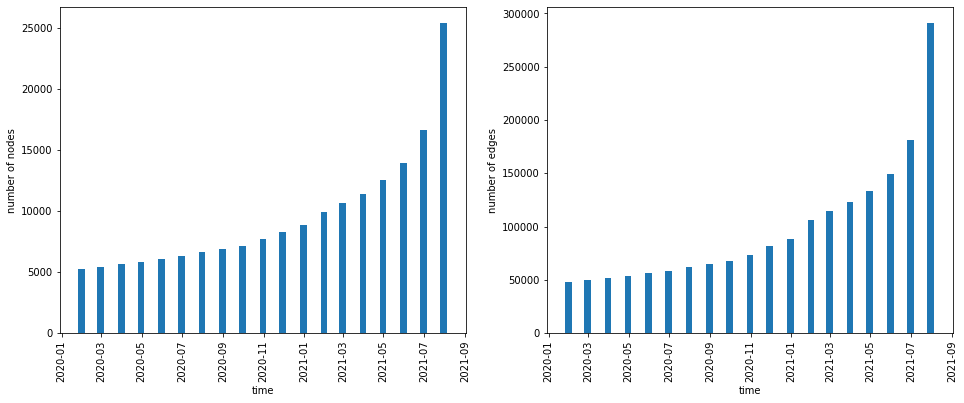

In [ ]:
n_nodes = []
n_edges = []
for G in dynamic_graphs:
  n_nodes.append(len(G.nodes()))
  n_edges.append(len(G.edges()))


plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.xticks(rotation='vertical')
plt.bar(snapshot_time_points, n_nodes, width=10)
plt.xlabel('time')
plt.ylabel('number of nodes')

plt.subplot(1,2,2)
plt.xticks(rotation='vertical')
plt.bar(snapshot_time_points, n_edges, width=10)
plt.xlabel('time')
plt.ylabel('number of edges')

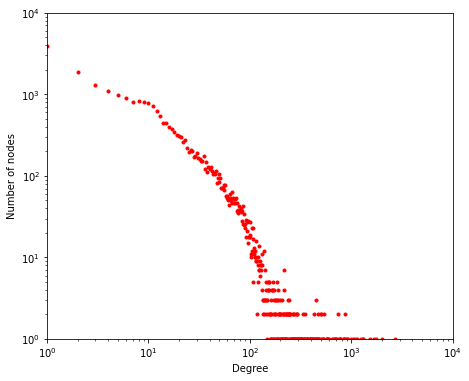

In [ ]:
degree_sequence = sorted((d for n, d in dynamic_graphs[-1].degree()), reverse=True)

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(*np.unique(degree_sequence, return_counts=True), 'ro', markersize=3)
ax.set_xlabel("Degree")
ax.set_ylabel('Number of nodes')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim([1e0, 1e4])
plt.ylim([1e0, 1e4])
plt.show()

In [ ]:
# methods = [algorithms.louvain, algorithms.infomap, algorithms.label_propagation, algorithms.walktrap]

# dynamic_coms = []
# for G in tqdm(dynamic_graphs, total=len(dynamic_graphs)):
#   comms_l = dict()
#   for comms in ensemble.pool(G, methods, configurations=[[], [], [], []]):
#     print(comms.method_name)
#     print([len(communities) for communities in comms.communities])
#     comms_l[comms.method_name] = comms
#   dynamic_coms.append(comms_l)

  0%|          | 0/19 [00:00<?, ?it/s]

Louvain
[2181, 353, 350, 262, 258, 187, 130, 109, 104, 101, 99, 85, 80, 79, 68, 62, 59, 56, 53, 51, 51, 45, 43, 37, 36, 28, 28, 28, 26, 20, 16, 10, 7, 7, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
Infomap
[4847, 180, 105, 16, 12, 9, 7, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
Label Propagation
[4677, 92, 54, 51, 44, 32, 26, 22, 21, 20, 16, 13, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]


  5%|▌         | 1/19 [00:07<02:11,  7.33s/it]

Walktrap
[3997, 107, 85, 72, 69, 67, 53, 52, 50, 48, 45, 42, 25, 24, 23, 23, 22, 20, 16, 16, 15, 10, 8, 7, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2223, 336, 311, 253, 213, 206, 158, 138, 112, 107, 98, 98, 96, 90, 85, 64, 60, 56, 56, 53, 51, 51, 49, 34, 34, 28, 28, 28, 26, 26, 25, 22, 21, 19, 18, 16, 15, 7, 7, 6, 6, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Infom

 11%|█         | 2/19 [00:17<02:33,  9.00s/it]

Walktrap
[4088, 96, 79, 73, 69, 68, 54, 53, 50, 48, 48, 45, 42, 35, 25, 24, 23, 23, 22, 20, 16, 16, 15, 8, 8, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2036, 896, 255, 235, 208, 174, 147, 113, 107, 99, 93, 88, 85, 73, 71, 59, 58, 55, 54, 54, 53, 51, 47, 44, 41, 32, 32, 30, 28, 26, 24, 22, 18, 16, 11, 10, 10, 9, 7, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

 16%|█▌        | 3/19 [00:27<02:34,  9.68s/it]

Walktrap
[4470, 96, 73, 69, 69, 53, 52, 52, 50, 45, 45, 35, 29, 26, 24, 23, 22, 21, 17, 16, 15, 11, 10, 8, 8, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2094, 864, 410, 250, 221, 177, 147, 131, 117, 89, 85, 84, 83, 82, 74, 65, 64, 55, 54, 53, 51, 50, 48, 44, 39, 35, 34, 31, 28, 26, 19, 16, 11, 11, 11, 10, 9, 8, 7, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Infomap
[5388, 194, 118, 18, 17, 16, 7, 5, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Label Propag

 21%|██        | 4/19 [00:36<02:20,  9.40s/it]

Walktrap
[4752, 112, 73, 70, 68, 53, 53, 52, 50, 46, 45, 35, 24, 23, 22, 22, 22, 16, 14, 13, 9, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Louvain
[2407, 354, 344, 343, 254, 248, 184, 176, 149, 135, 126, 99, 92, 72, 64, 62, 55, 53, 52, 51, 50, 50, 48, 47, 43, 42, 36, 35, 34, 32, 32, 28, 26, 20, 16, 12, 11, 9, 9, 9, 7, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Infomap
[5619, 195, 127, 19, 16, 7, 6, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
Label Propagation
[5326, 118, 54, 51, 50, 45, 44, 32, 22, 21, 20, 16, 15

 26%|██▋       | 5/19 [00:45<02:08,  9.20s/it]

Walktrap
[4893, 121, 72, 70, 69, 55, 54, 53, 53, 50, 45, 36, 24, 23, 22, 22, 19, 16, 14, 13, 10, 10, 9, 9, 8, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Louvain
[2438, 543, 385, 264, 254, 180, 155, 151, 151, 133, 113, 99, 92, 90, 89, 73, 63, 61, 60, 60, 59, 59, 56, 56, 55, 53, 51, 50, 42, 31, 30, 28, 26, 24, 20, 16, 16, 12, 11, 11, 10, 9, 7, 6, 6, 6, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Infomap
[5894, 196, 134, 16, 7, 6, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Label P

 32%|███▏      | 6/19 [00:58<02:14, 10.32s/it]

Walktrap
[5080, 127, 72, 70, 65, 53, 53, 53, 50, 45, 44, 38, 27, 24, 23, 22, 21, 21, 19, 16, 15, 14, 13, 10, 10, 9, 8, 8, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2485, 481, 449, 336, 280, 270, 186, 150, 140, 135, 131, 109, 94, 82, 69, 64, 61, 57, 56, 54, 54, 53, 53, 52, 50, 43, 41, 40, 40, 38, 33, 30, 29, 28, 26, 24, 22, 21, 20, 16, 10, 10, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Infomap
[6161, 196, 140, 16, 7, 6, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,

 37%|███▋      | 7/19 [01:10<02:09, 10.78s/it]

Walktrap
[5269, 123, 72, 71, 65, 55, 53, 52, 50, 45, 44, 36, 36, 28, 28, 24, 23, 23, 21, 16, 16, 14, 13, 10, 9, 9, 9, 8, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2594, 719, 466, 291, 276, 168, 151, 147, 146, 145, 131, 110, 100, 100, 84, 57, 57, 56, 54, 53, 53, 53, 50, 50, 50, 44, 44, 37, 33, 33, 33, 33, 32, 32, 30, 29, 26, 21, 21, 20, 16, 12, 11, 11, 10, 8, 7, 7, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]


 42%|████▏     | 8/19 [01:22<02:03, 11.24s/it]

Walktrap
[5665, 127, 71, 71, 66, 56, 53, 52, 46, 45, 43, 36, 28, 28, 24, 23, 23, 21, 16, 14, 13, 10, 9, 9, 9, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
Louvain
[2606, 696, 415, 367, 322, 277, 256, 146, 131, 129, 111, 104, 97, 97, 82, 73, 70, 62, 61, 57, 56, 55, 53, 53, 53, 52, 50, 49, 47, 46, 43, 34, 34, 31, 30, 30, 29, 27, 16, 12, 11, 10, 10, 10, 8, 7, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
Infomap
[6833, 191, 16, 8, 8, 7, 7, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

 47%|████▋     | 9/19 [01:37<02:05, 12.55s/it]

Walktrap
[5710, 106, 72, 66, 64, 56, 53, 50, 49, 45, 42, 41, 41, 38, 28, 24, 24, 23, 23, 21, 19, 19, 17, 16, 16, 14, 13, 13, 10, 10, 9, 9, 8, 8, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2840, 419, 393, 390, 343, 309, 283, 246, 193, 180, 156, 141, 131, 105, 99, 86, 78, 68, 66, 59, 58, 55, 55, 53, 50, 50, 44, 44, 41, 41, 39, 39, 39, 37, 33, 31, 30, 30, 26, 22, 21, 21, 20, 16, 13, 13, 10, 9, 9, 7, 7, 6, 6, 6, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3

 53%|█████▎    | 10/19 [01:53<02:02, 13.64s/it]

Walktrap
[5856, 203, 105, 84, 70, 64, 60, 55, 53, 46, 46, 45, 43, 42, 41, 38, 35, 28, 25, 24, 23, 23, 21, 19, 19, 18, 16, 14, 13, 13, 13, 10, 9, 9, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[2688, 950, 699, 372, 328, 303, 296, 203, 185, 18

 58%|█████▊    | 11/19 [02:10<01:57, 14.63s/it]

Walktrap
[6552, 93, 71, 68, 65, 62, 62, 56, 53, 47, 46, 45, 42, 41, 39, 38, 35, 35, 28, 28, 24, 23, 21, 19, 17, 16, 15, 14, 12, 10, 9, 9, 9, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 63%|██████▎   | 12/19 [02:36<02:06, 18.00s/it]

Walktrap
[7120, 93, 79, 72, 68, 62, 57, 53, 52, 48, 46, 45, 44, 41, 37, 35, 34, 31, 28, 27, 24, 23, 23, 21, 19, 16, 14, 13, 10, 10, 10, 9, 9, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

 68%|██████▊   | 13/19 [03:00<01:59, 19.94s/it]

Walktrap
[8338, 129, 117, 67, 67, 63, 57, 53, 51, 48, 47, 45, 41, 38, 38, 28, 25, 24, 23, 21, 19, 19, 19, 16, 15, 14, 12, 10, 10, 9, 9, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Louvain
[3094, 1495, 1472, 463, 412, 360, 234, 193, 181, 173, 164, 148, 144, 132, 126, 111, 109, 93, 88, 81, 77, 71, 70, 67, 65, 61, 58, 58, 54, 53, 50, 47, 44, 40, 37, 34, 33, 32, 28, 26, 25, 23, 22, 19, 15, 12, 10, 10, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2

 74%|███████▎  | 14/19 [03:30<01:55, 23.00s/it]

Walktrap
[8768, 107, 80, 69, 69, 66, 56, 55, 48, 47, 45, 45, 41, 40, 39, 38, 36, 36, 28, 26, 24, 24, 23, 23, 21, 19, 16, 14, 12, 10, 10, 10, 9, 9, 9, 7, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 79%|███████▉  | 15/19 [04:08<01:49, 27.36s/it]

Walktrap
[9458, 116, 107, 68, 68, 64, 56, 56, 55, 48, 48, 47, 46, 44, 40, 39, 38, 34, 34, 33, 28, 23, 23, 21, 19, 16, 16, 14, 13, 12, 11, 10, 10, 9, 9, 9, 8, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

 84%|████████▍ | 16/19 [04:39<01:25, 28.65s/it]

Walktrap
[10138, 123, 110, 84, 69, 68, 60, 59, 56, 54, 52, 51, 49, 49, 47, 46, 46, 45, 39, 39, 36, 34, 32, 28, 26, 23, 23, 21, 18, 16, 16, 14, 13, 13, 13, 12, 12, 10, 10, 9, 9, 9, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 89%|████████▉ | 17/19 [05:31<01:10, 35.41s/it]

Walktrap
[11550, 123, 122, 100, 66, 66, 60, 55, 55, 54, 53, 52, 51, 48, 47, 46, 45, 45, 38, 38, 37, 37, 34, 31, 28, 23, 22, 21, 19, 18, 16, 16, 14, 14, 13, 12, 12, 10, 10, 9, 9, 9, 9, 8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

 95%|█████████▍| 18/19 [06:35<00:44, 44.27s/it]

Walktrap
[13358, 281, 123, 122, 103, 84, 68, 68, 63, 63, 60, 55, 52, 51, 48, 48, 47, 46, 46, 46, 44, 41, 37, 37, 36, 34, 34, 31, 30, 29, 25, 24, 24, 22, 22, 21, 20, 19, 19, 16, 16, 13, 13, 13, 13, 12, 10, 10, 10, 10, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

100%|██████████| 19/19 [08:44<00:00, 27.60s/it]

Walktrap
[19802, 619, 299, 290, 170, 141, 129, 122, 114, 102, 101, 73, 69, 64, 64, 62, 57, 57, 55, 55, 53, 53, 51, 49, 48, 46, 46, 46, 43, 43, 42, 41, 40, 39, 38, 35, 35, 35, 34, 33, 33, 32, 31, 29, 26, 25, 24, 24, 24, 22, 21, 21, 21, 20, 17, 16, 15, 15, 15, 14, 14, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

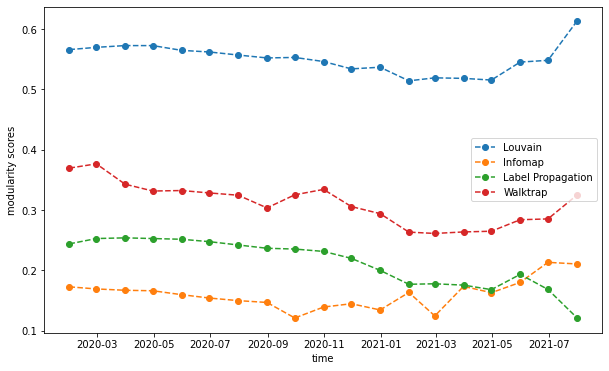

In [ ]:
# hub_dominance_scores = {}
# conductance_scores = {}
# modularity_scores = {}

# for t in range(len(dynamic_graphs)):
#   G = dynamic_graphs[t]
#   for comm in dynamic_coms[t].values():
#     if comm.method_name in hub_dominance_scores:
#       # hub_dominance_scores[comm.method_name].append(evaluation.hub_dominance(G, comm)[2])
#       # conductance_scores[comm.method_name].append(evaluation.conductance(G, comm)[2])
#       modularity_scores[comm.method_name].append(evaluation.newman_girvan_modularity(G, comm)[2])
#     else:
#       hub_dominance_scores[comm.method_name] = [evaluation.hub_dominance(G, comm)[2]]
#       conductance_scores[comm.method_name] = [evaluation.conductance(G, comm)[2]]
#       modularity_scores[comm.method_name] = [evaluation.newman_girvan_modularity(G, comm)[2]]

# plt.figure(figsize=(10, 6))
# # for method in hub_dominance_scores:
# #   plt.plot(snapshot_time_points, hub_dominance_scores[method], "--o", label=method)
# # plt.xlabel("time")
# # plt.ylabel("hub dominance score")
# # plt.legend()

# # plt.subplot(1, 3, 2)
# # for method in conductance_scores:
# #   plt.plot(snapshot_time_points, conductance_scores[method], "--o", label=method)
# # plt.xlabel("time")
# # plt.ylabel("conductance scores")
# # plt.legend()

# for method in modularity_scores:
#   plt.plot(snapshot_time_points, modularity_scores[method], "--o", label=method)
# plt.xlabel("time")
# plt.ylabel("modularity scores")
# plt.legend()

In [ ]:
# comm_louvain = [comm['Louvain'] for comm in dynamic_coms]
# for t in range(len(snapshot_time_points)):
#   coms = comm_louvain[t]
#   timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
#   readwrite.write_community_csv(coms, f'social network/snapshots/communities/louvain/{timestr}.csv', ",")

In [ ]:
# time_2_sorted_comm = dict()

# for t in tqdm(range(len(snapshot_time_points)), total=len(snapshot_time_points)):
#   timestr = snapshot_time_points[t].strftime('%Y-%m-%d')
#   G = nx.read_gexf(f"social network/snapshots/graph/{timestr}.gexf")
#   coms = readwrite.read_community_csv(f"social network/snapshots/communities/louvain/{timestr}.csv")
#   time_2_sorted_comm[t] = dict()
#   for cid, community in tqdm(enumerate(coms.communities), total=len(coms.communities)):
#     subG = G.subgraph(community)
#     close_central = nx.closeness_centrality(subG)
#     sorted_close_central = sorted(close_central.items(), key=lambda x: x[1], reverse=True)
#     time_2_sorted_comm[t][f"{t}_{cid}"] = sorted_close_central
#   with open("social network/louvain_sorted_closeness_central_nodes.pickle", "wb") as f:
#     pickle.dump(time_2_sorted_comm, f, protocol=pickle.HIGHEST_PROTOCOL)

# # CHECKPOINT
# with open("social network/louvain_sorted_closeness_central_nodes.pickle", "wb") as f:
#   pickle.dump(time_2_sorted_comm, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open("social network/louvain_sorted_closeness_central_nodes.pickle", "rb") as f:
#   test = pickle.load(f)

# print(test == time_2_sorted_comm)

100%|██████████| 19/19 [1:59:59<00:00, 378.93s/it] 


True


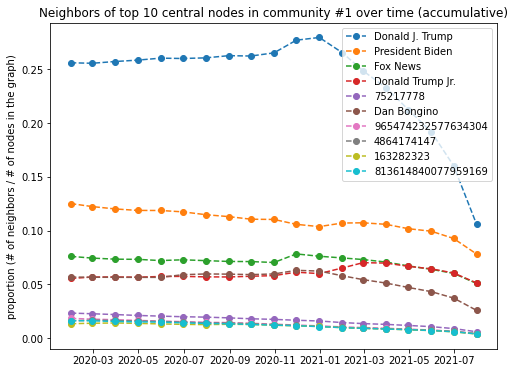

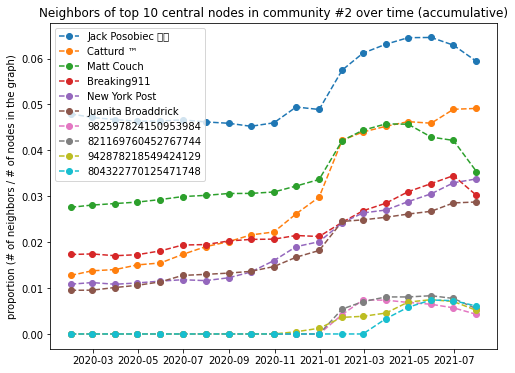

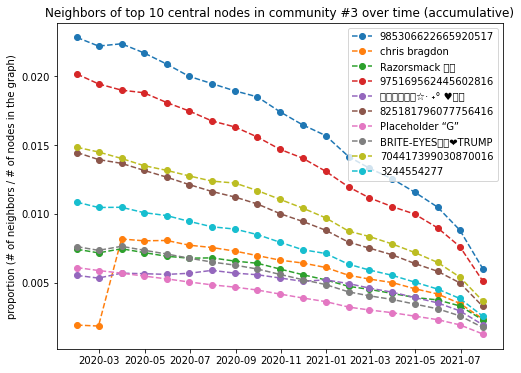

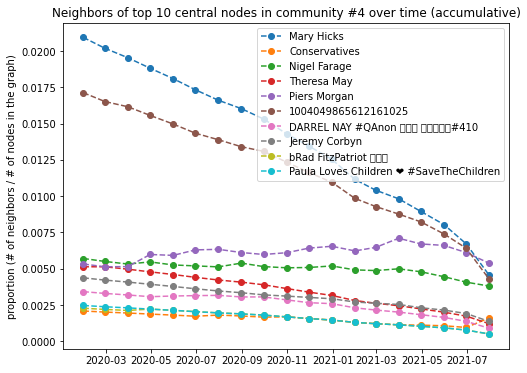

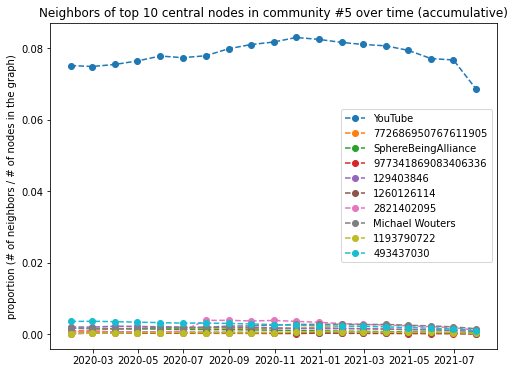

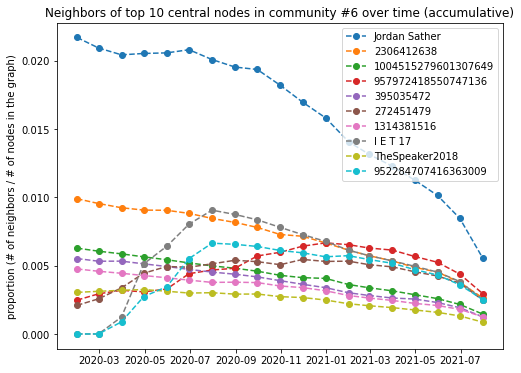

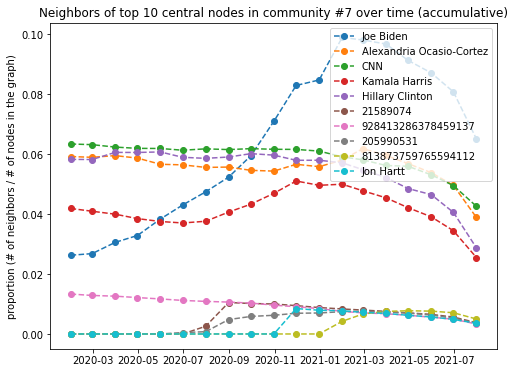

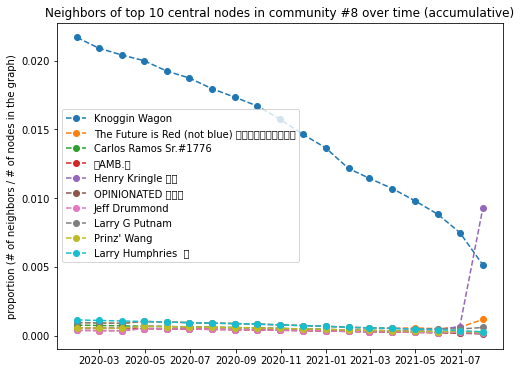

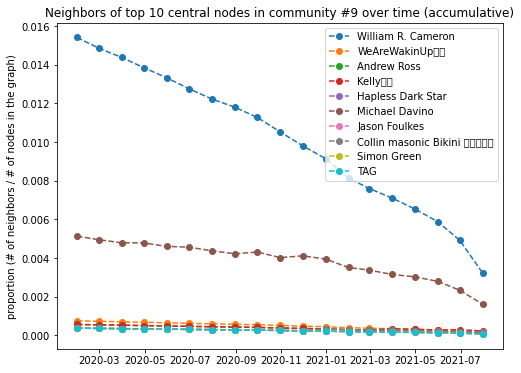

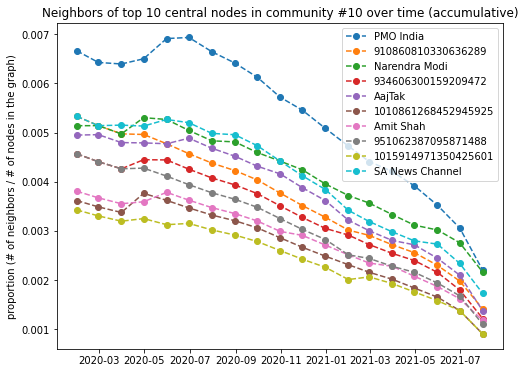

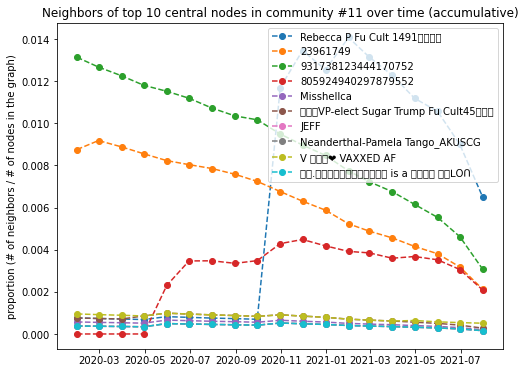

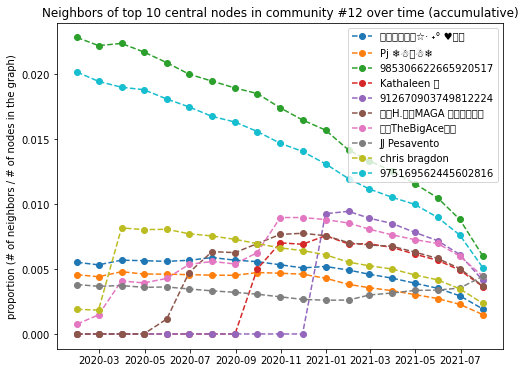

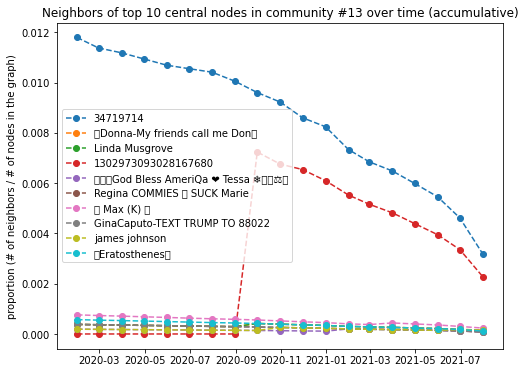

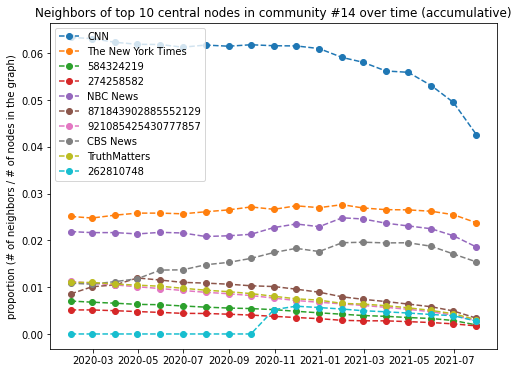

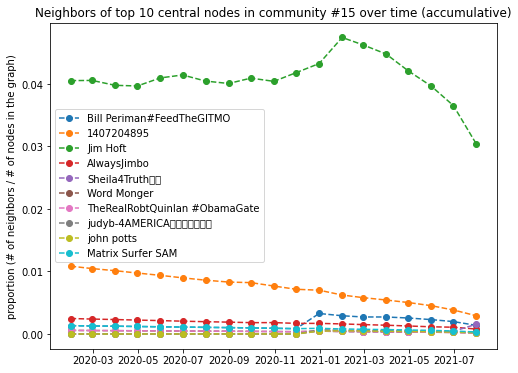

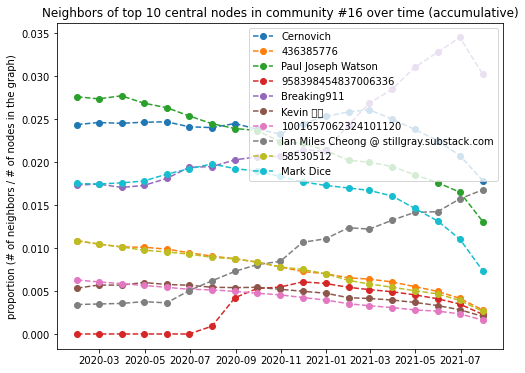

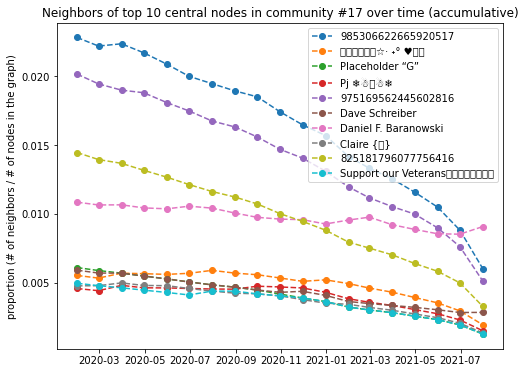

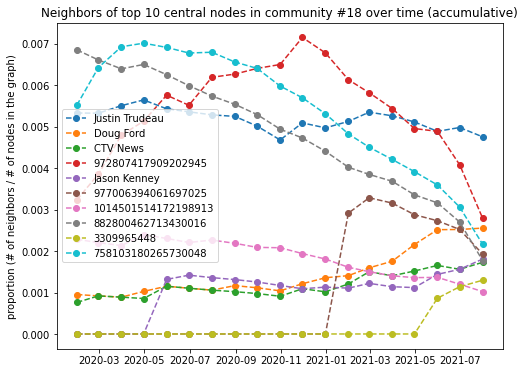

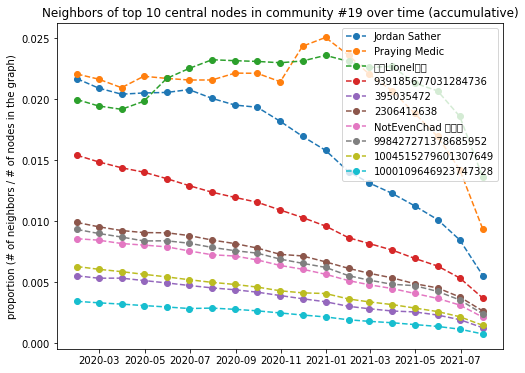

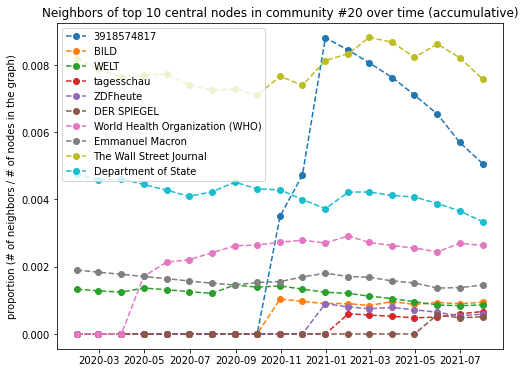

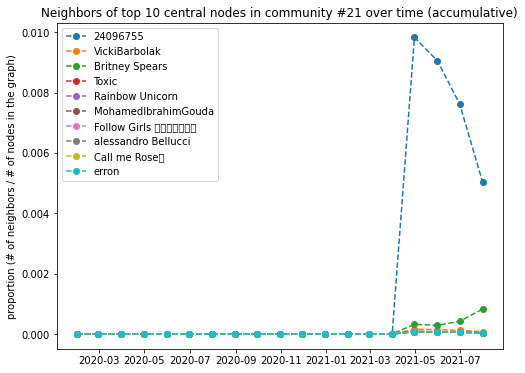

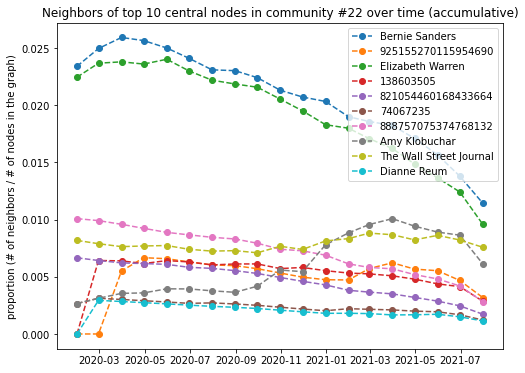

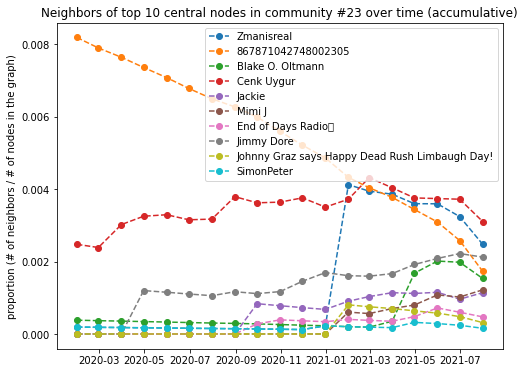

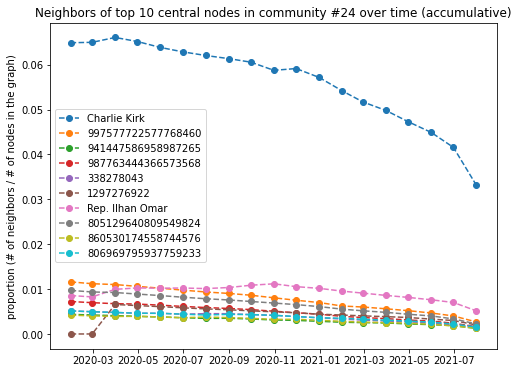

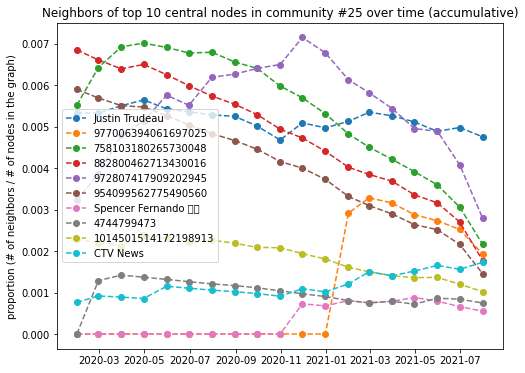

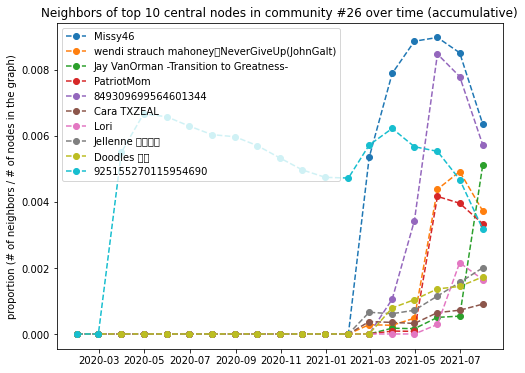

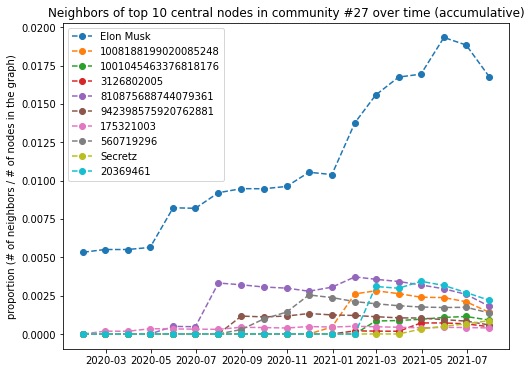

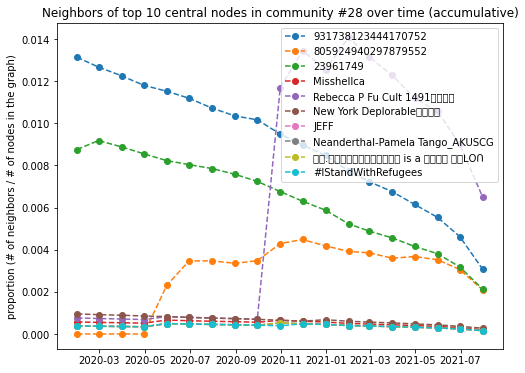

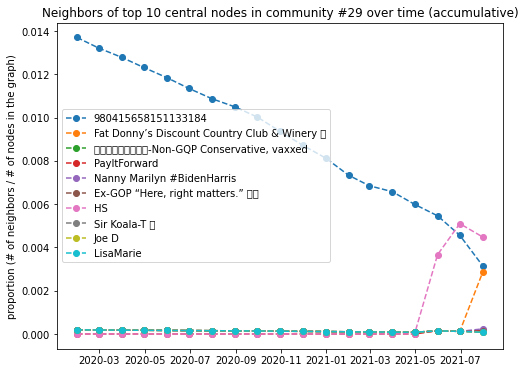

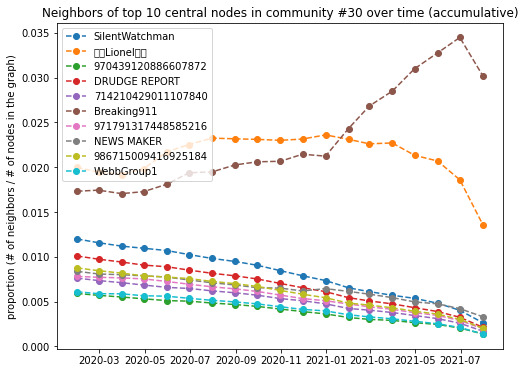

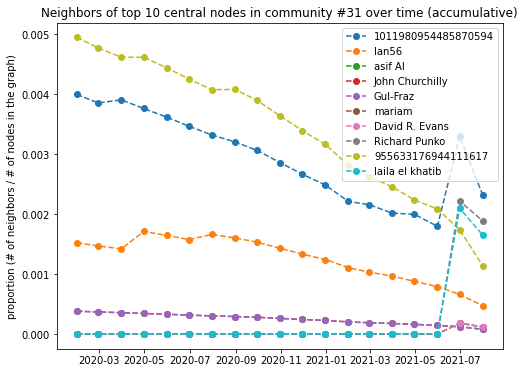

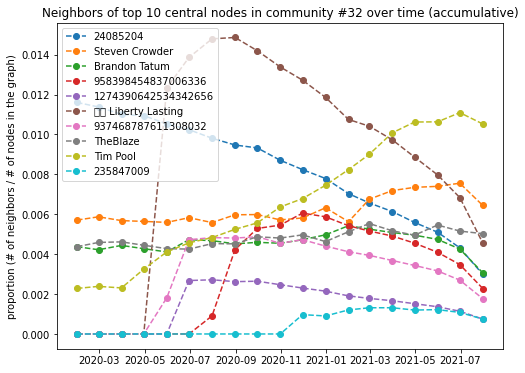

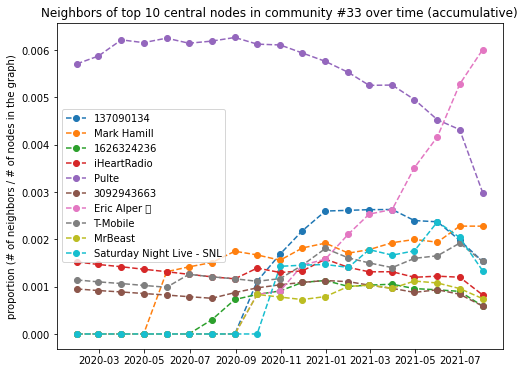

In [ ]:

for t, comm_nodes in enumerate(comm_sorted_users):
# comm_nodes = comm_sorted_users[0]

  node_prob = dict()

  for comm, nodes in comm_nodes:
    time = int(comm.split('_')[0])
    for node, prob in nodes:
      if node not in node_prob.keys():
        node_prob[node] = [(0, 0)]*len(snapshot_time_points)
      accum_p, times = node_prob[node][time]
      node_prob[node][time] = (prob+accum_p, times+1)


  node_central_score = dict()
  for node in node_prob:
    node_scores = np.zeros(len(snapshot_time_points))
    for i in range(len(snapshot_time_points)):
      if node_prob[node][i][1]:
        node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
      else:
        node_scores[i] = 0
    node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

  sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
  sorted_nodes = [node for node, _ in sorted_node_prob]
  central_nodes = sorted_nodes[:10]

  plt.figure(figsize=(8, 6))
  for i, central_node in enumerate(central_nodes):
    n_neighbors = []
    for G in dynamic_graphs:
      if central_node in G.nodes():
        n_neighbors.append(len(list(nx.neighbors(G, central_node)))/len(list(G.nodes())))
      else:
        n_neighbors.append(0)
    if int(central_node) in entityid2name:
      label = entityid2name[int(central_node)]
    else:
      label = central_node
    plt.plot(snapshot_time_points, n_neighbors, '--o', label=label)
  plt.ylabel('proportion (# of neighbors / # of nodes in the graph)')
  plt.title(f'Neighbors of top 10 central nodes in community #{t+1} over time (accumulative)')
  plt.legend()

# central_node = central_nodes[0]
# neighbors_over_time = []
# for G in dynamic_graphs:
#   neighbors_over_time.append([int(x) for x in list(nx.neighbors(G, central_node))])

# volume_over_time = []
# tweets_over_time = []

# previous_volume = 0
# previous_tweet_ids = set()
# for neighbors in neighbors_over_time:
#   current_tweets = all_tweets_df[all_tweets_df['user_id'].isin(neighbors)]
#   current_volume = len(current_tweets)
#   tweets_over_time.append(list(set(current_tweets['id'].values).difference(previous_tweet_ids)))
#   volume_over_time.append(current_volume - previous_volume)
#   previous_volume = current_volume
#   previous_tweet_ids = set(current_tweets['id'].values)
#   # print(len(list(set(current_tweets['id'].values).difference(previous_tweet_ids))) == current_volume - previous_volume)

# plt.subplot(2, 1, 2, sharex = ax1)
# plt.bar(snapshot_time_points[1:], volume_over_time[1:], width=10)
# plt.xlabel('time')
# plt.ylabel('number of tweets')
# plt.title('tweets interact with the central node in the largest community')

In [ ]:
all_tweets_df_time_index = all_tweets_df.copy()
all_tweets_df_time_index.index = pd.to_datetime(all_tweets_df['time'], infer_datetime_format=True)
all_tweets_df_time_index = all_tweets_df_time_index.sort_index()
all_tweets_df_time_index

id  \
time                                             
2009-01-28 00:59:00+00:00           1153845281   
2009-02-05 01:00:40+00:00           1178221904   
2009-02-26 01:18:00+00:00           1251764213   
2009-03-01 00:30:40+00:00           1263823080   
2009-03-08 03:03:29+00:00           1295076660   
...                                        ...   
2021-08-02 22:36:31+00:00  1422325468339097609   
2021-08-02 22:37:03+00:00  1422325602506338332   
2021-08-02 22:37:30+00:00  1422325714821410832   
2021-08-02 22:38:08+00:00  1422325874532274179   
2021-08-02 22:38:37+00:00  1422325997106565120   

                                                                        text  \
time                                                                           
2009-01-28 00:59:00+00:00                       liz, i don't get it.... haha   
2009-02-05 01:00:40+00:00                           i still dont get it.....   
2009-02-26 01:18:00+00:00  @thFOOL film- alamo draft house all day and mu...   
2009-03-01 00:30:40+00:00                                            working   
2009-03-08 03:03:29+00:00                             mtel's today.... yucky   
...                                                                      ...   
2021-08-02 22:36:31+00:00                            https://t.co/DFtBHMZMsc   
2021-08-02 22:37:03+00:00  The world needs answers: When will the Dems ba...   
2021-08-02 22:37:30+00:00  👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻THIS explains it https://t.co/BHhh...   
2021-08-02 22:38:08+00:00               @Murder_Fancier Next level ignorance   
2021-08-02 22:38:37+00:00  This is outrageous. How true is it?\n\nIslam i...   

                                                     time             user_id  \
time                                                                            
2009-01-28 00:59:00+00:00  Wed Jan 28 00:59:00 +0000 2009            18838098   
2009-02-05 01:00:40+00:00  Thu Feb 05 01:00:40 +0000 2009            18838098   
2009-02-26 01:18:00+00:00  Thu Feb 26 01:18:00 +0000 2009            17277830   
2009-03-01 00:30:40+00:00  Sun Mar 01 00:30:40 +0000 2009            22313953   
2009-03-08 03:03:29+00:00  Sun Mar 08 03:03:29 +0000 2009            18838098   
...                                                   ...                 ...   
2021-08-02 22:36:31+00:00  Mon Aug 02 22:36:31 +0000 2021            77244409   
2021-08-02 22:37:03+00:00  Mon Aug 02 22:37:03 +0000 2021           312149882   
2021-08-02 22:37:30+00:00  Mon Aug 02 22:37:30 +0000 2021  879199141271814144   
2021-08-02 22:38:08+00:00  Mon Aug 02 22:38:08 +0000 2021           233374516   
2021-08-02 22:38:37+00:00  Mon Aug 02 22:38:37 +0000 2021          3040416293   

                          user_screen_name  \
time                                         
2009-01-28 00:59:00+00:00     TheMrsBobcat   
2009-02-05 01:00:40+00:00     TheMrsBobcat   
2009-02-26 01:18:00+00:00      soundslike1   
2009-03-01 00:30:40+00:00        jdsmith87   
2009-03-08 03:03:29+00:00     TheMrsBobcat   
...                                    ...   
2021-08-02 22:36:31+00:00      deesbarbara   
2021-08-02 22:37:03+00:00       Chris_1791   
2021-08-02 22:37:30+00:00       Pammyreign   
2021-08-02 22:38:08+00:00  loveletters2007   
2021-08-02 22:38:37+00:00      roygsymonds   

                                                                cleaned_text  \
time                                                                           
2009-01-28 00:59:00+00:00                                   ['dont', 'haha']   
2009-02-05 01:00:40+00:00                                  ['still', 'dont']   
2009-02-26 01:18:00+00:00  ['film', 'alamo', 'draft', 'house', 'music', '...   
2009-03-01 00:30:40+00:00                                           ['work']   
2009-03-08 03:03:29+00:00                        ['mtels', 'today', 'yucky']   
...                                                                      ...   
2021-08-02 22:36:31+00:00                                  

In [ ]:
entityid2name_ascii = dict()
for id, name in entityid2name.items():
  entityid2name_ascii[id] = name.encode("ascii", errors="ignore").decode()

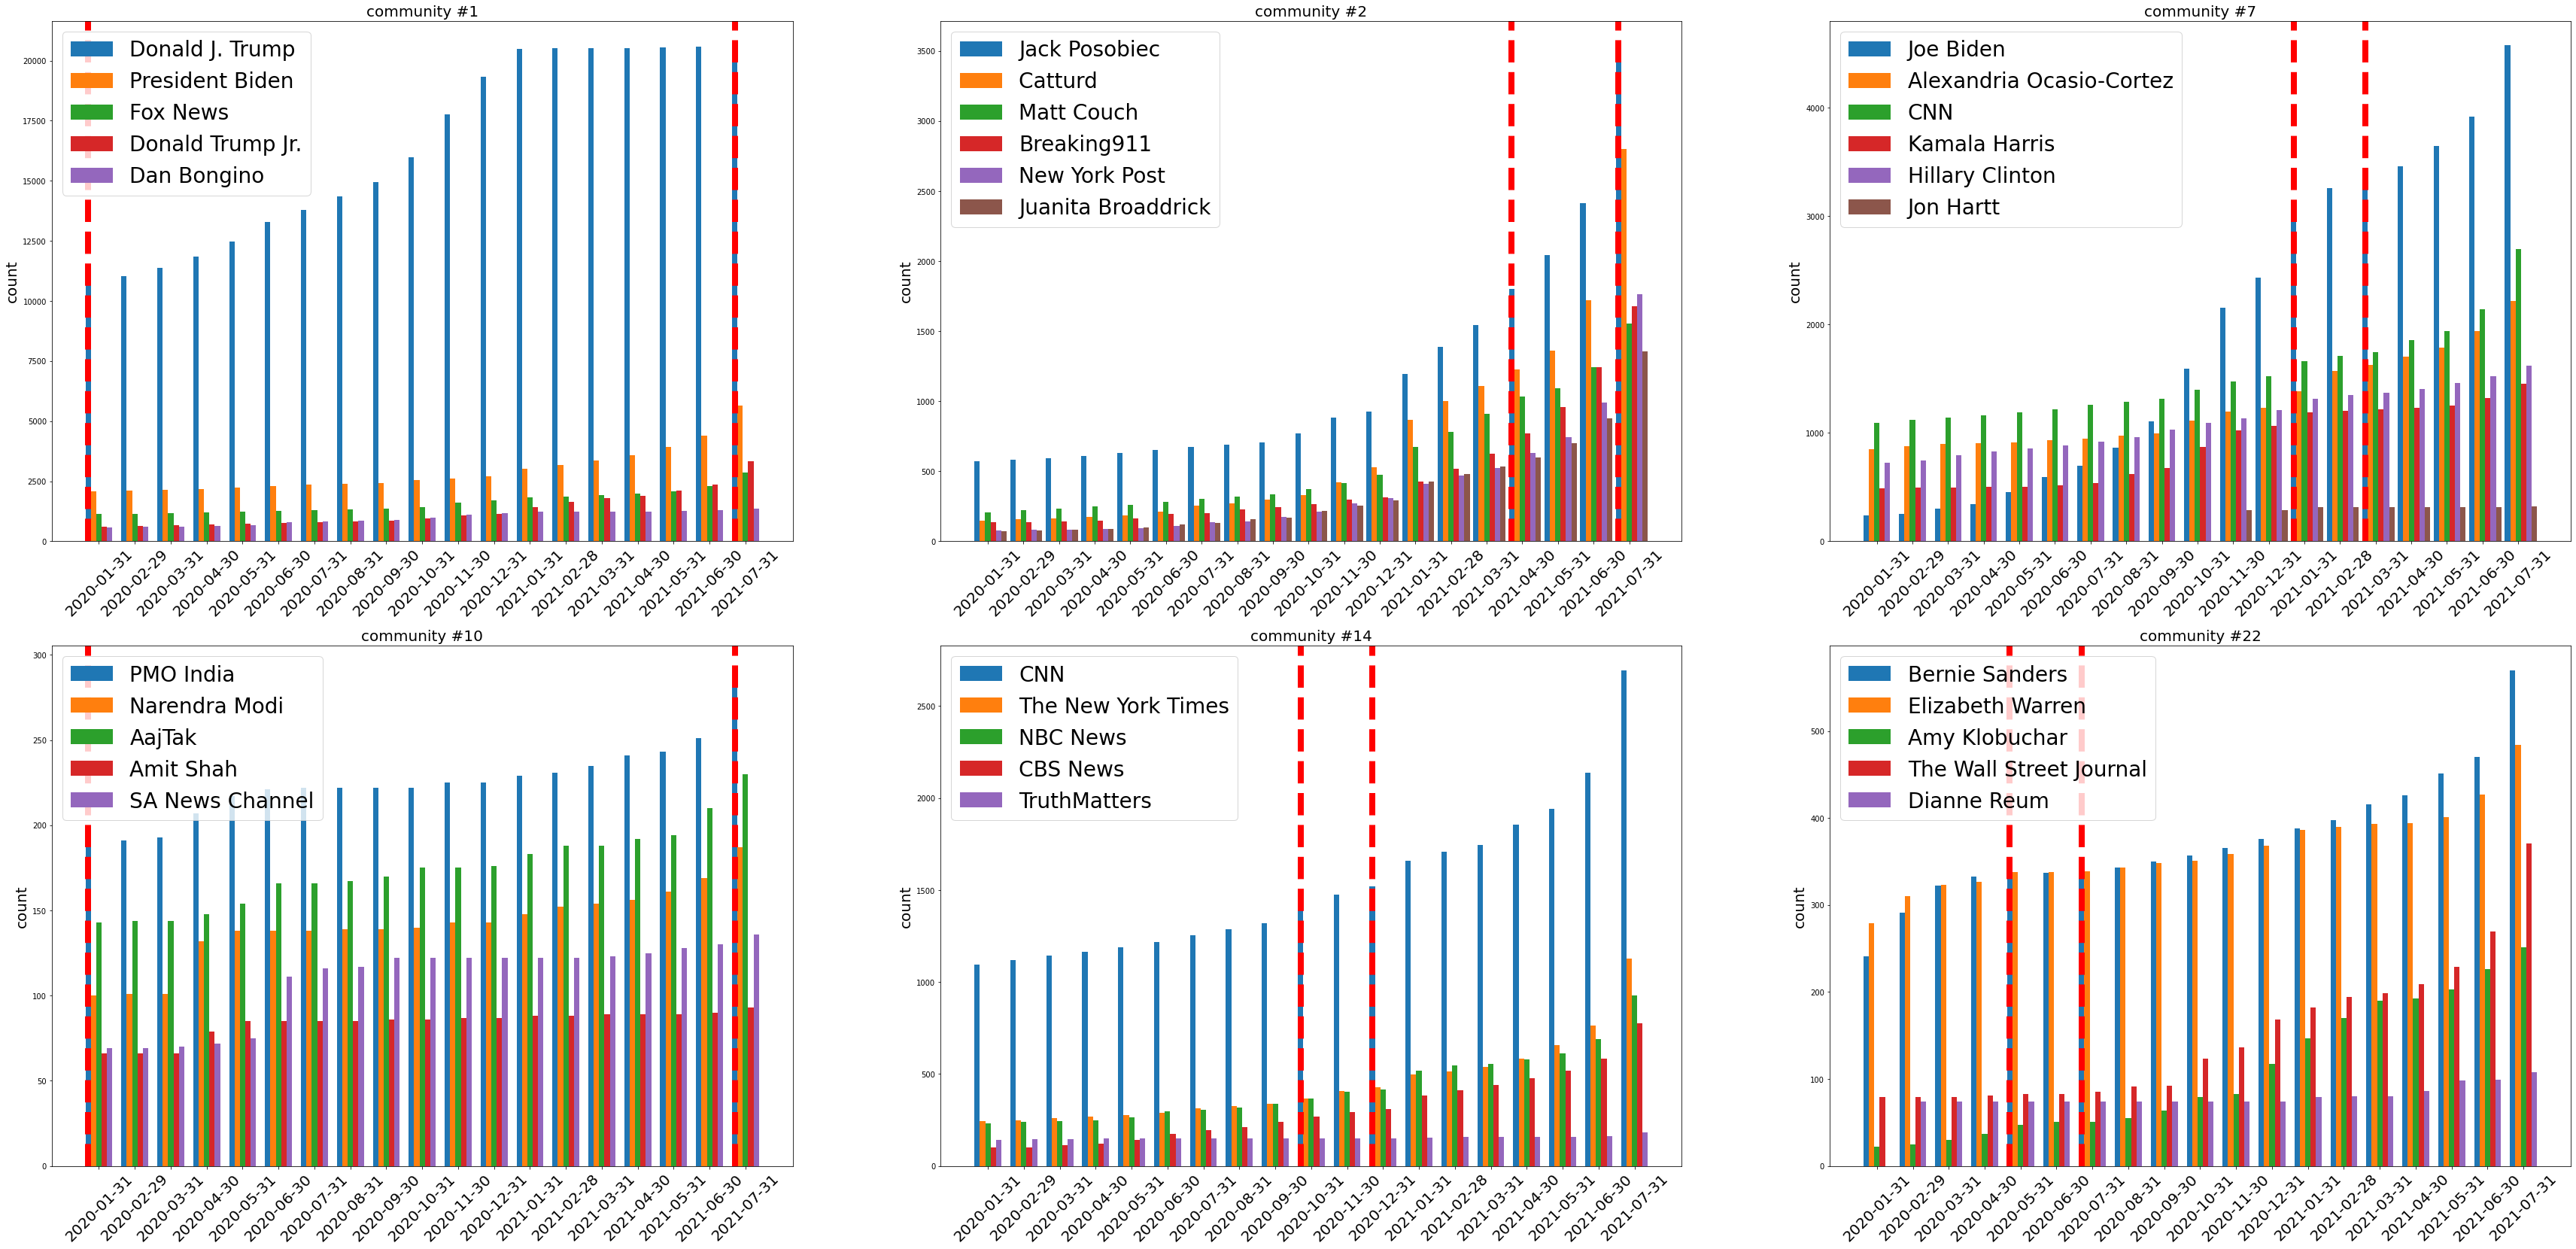

In [ ]:
plt.figure(figsize=(3*20, 2*14))
selected_coms = [1, 2, 7, 10, 14, 22]
count = 0
for t, comm_nodes in enumerate(comm_sorted_users):
  if (t+1) in selected_coms:
  # comm_nodes = comm_sorted_users[0]
    count += 1
    node_prob = dict()
    filtered_time = []
    for comm, nodes in comm_nodes:
      time = int(comm.split('_')[0])
      filtered_time.append(time)
      for node, prob in nodes:
        if node not in node_prob.keys():
          node_prob[node] = [(0, 0)]*len(snapshot_time_points)
        accum_p, times = node_prob[node][time]
        node_prob[node][time] = (prob+accum_p, times+1)


    node_central_score = dict()
    for node in node_prob:
      node_scores = np.zeros(len(snapshot_time_points))
      for i in range(len(snapshot_time_points)):
        if node_prob[node][i][1]:
          node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
        else:
          node_scores[i] = 0
      node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

    sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in sorted_node_prob]
    central_nodes = sorted_nodes[:10]

    plt.subplot(2, 3, count)
    br = np.arange(len(snapshot_time_points))
    for i, central_node in enumerate(central_nodes):
      if int(central_node) in entityid2name:
        prop_interactions = []
        start_time = datetime(2019, 12, 31).strftime('%Y-%m-%d')
        for time, G in enumerate(dynamic_graphs):
          end_time = snapshot_time_points[time].strftime('%Y-%m-%d')
          n_tweets = len(all_tweets_df_time_index.loc[start_time:end_time])
          start_time = end_time
          if central_node in G.nodes():
            current_interactions = G.degree(central_node, weight='weight')
            prop_interactions.append(current_interactions)
          else:
            prop_interactions.append(0)
        bar_width=0.15
        plt.bar(br, prop_interactions, width=bar_width,  label=entityid2name_ascii[int(central_node)])
        br = [x + bar_width for x in br]
    plt.axvline(x=filtered_time[0], color='r', ls='--', linewidth=8)
    plt.axvline(x=filtered_time[-1], color='r', ls='--', linewidth=8)
    plt.ylabel('count', fontsize=20)
    plt.xticks([r+2*bar_width for r in range(len(snapshot_time_points))],
        [x.strftime('%Y-%m-%d') for x in snapshot_time_points], rotation=45, fontsize=20)
    plt.title(f'community #{t+1}', fontsize=20)
    plt.legend(fontsize=28)


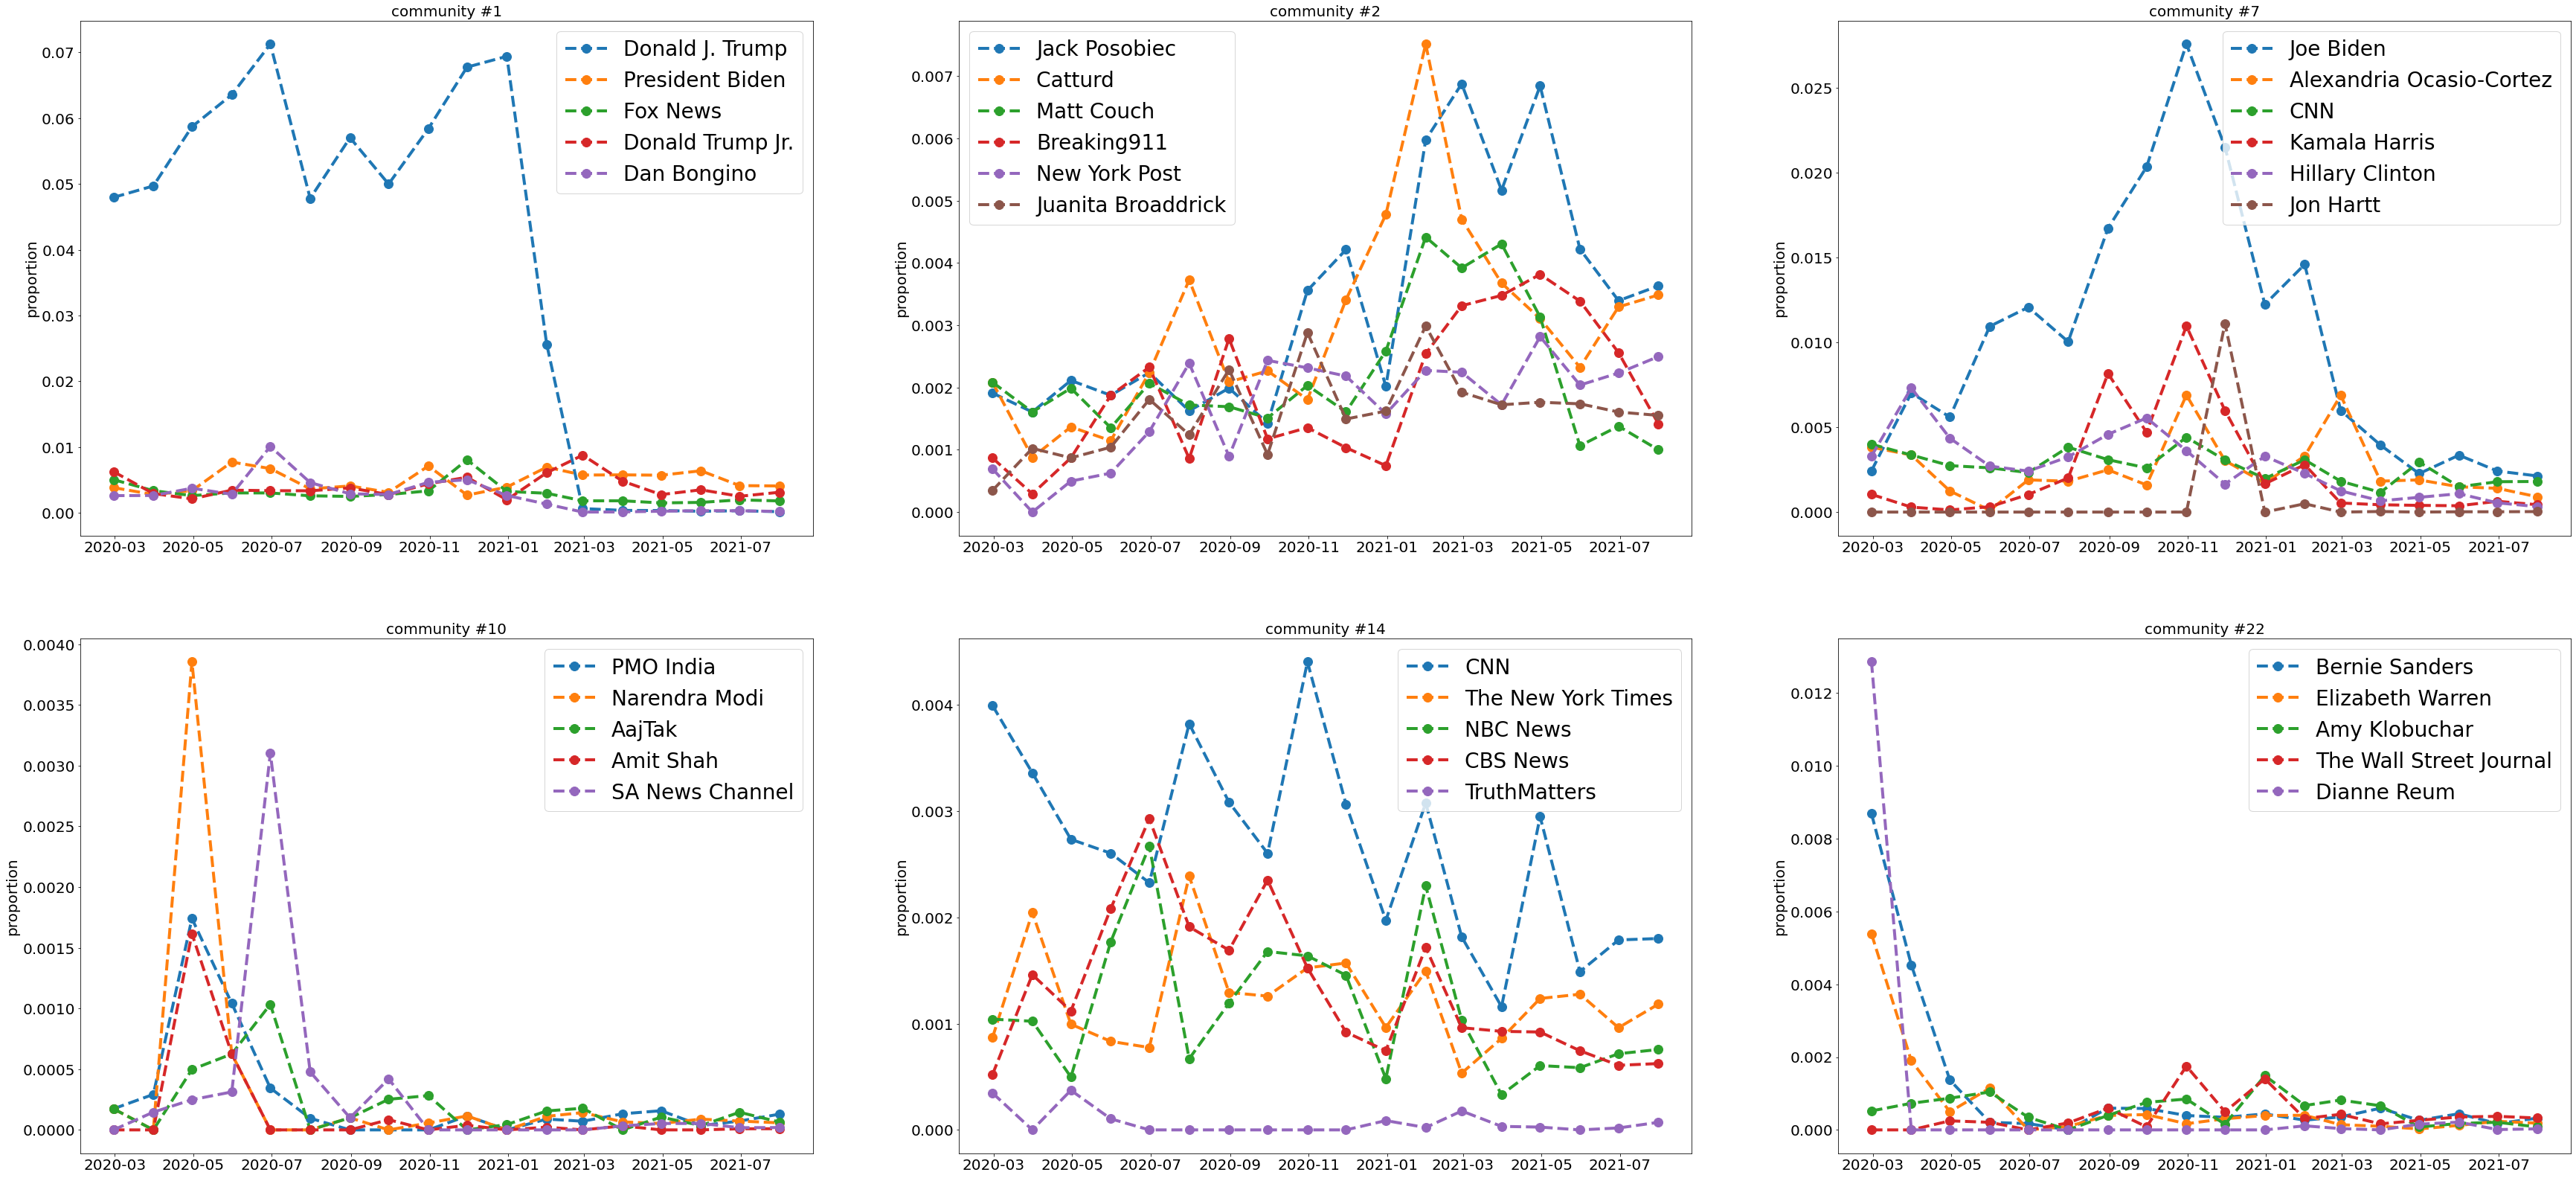

In [ ]:
plt.figure(figsize=(3*20, 2*14))
count = 0
for t, comm_nodes in enumerate(comm_sorted_users):
  if t+1 in selected_coms:
    count += 1
# comm_nodes = comm_sorted_users[0]

    node_prob = dict()

    for comm, nodes in comm_nodes:
      time = int(comm.split('_')[0])
      for node, prob in nodes:
        if node not in node_prob.keys():
          node_prob[node] = [(0, 0)]*len(snapshot_time_points)
        accum_p, times = node_prob[node][time]
        node_prob[node][time] = (prob+accum_p, times+1)


    node_central_score = dict()
    for node in node_prob:
      node_scores = np.zeros(len(snapshot_time_points))
      for i in range(len(snapshot_time_points)):
        if node_prob[node][i][1]:
          node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
        else:
          node_scores[i] = 0
      node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

    sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in sorted_node_prob]
    central_nodes = sorted_nodes[:10]

    plt.subplot(2, 3, count)
    for i, central_node in enumerate(central_nodes):
      if int(central_node) in entityid2name:
        prop_interactions = []
        previous_interactions = 0
        start_time = datetime(2019, 12, 31).strftime('%Y-%m-%d')
        for time, G in enumerate(dynamic_graphs):
          end_time = snapshot_time_points[time].strftime('%Y-%m-%d')
          n_tweets = len(all_tweets_df_time_index.loc[start_time:end_time])
          start_time = end_time
          if central_node in G.nodes():
            current_interactions = G.degree(central_node, weight='weight')
            prop_interactions.append((current_interactions - previous_interactions)/n_tweets)
            previous_interactions = current_interactions
          else:
            prop_interactions.append(0)
        plt.plot(snapshot_time_points[1:], prop_interactions[1:], '--o', label=entityid2name_ascii[int(central_node)], linewidth=4, markersize=12)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
  
    plt.ylabel('proportion', fontsize=20)
    plt.title(f'community #{t+1}', fontsize=20)
    plt.legend(fontsize=28)

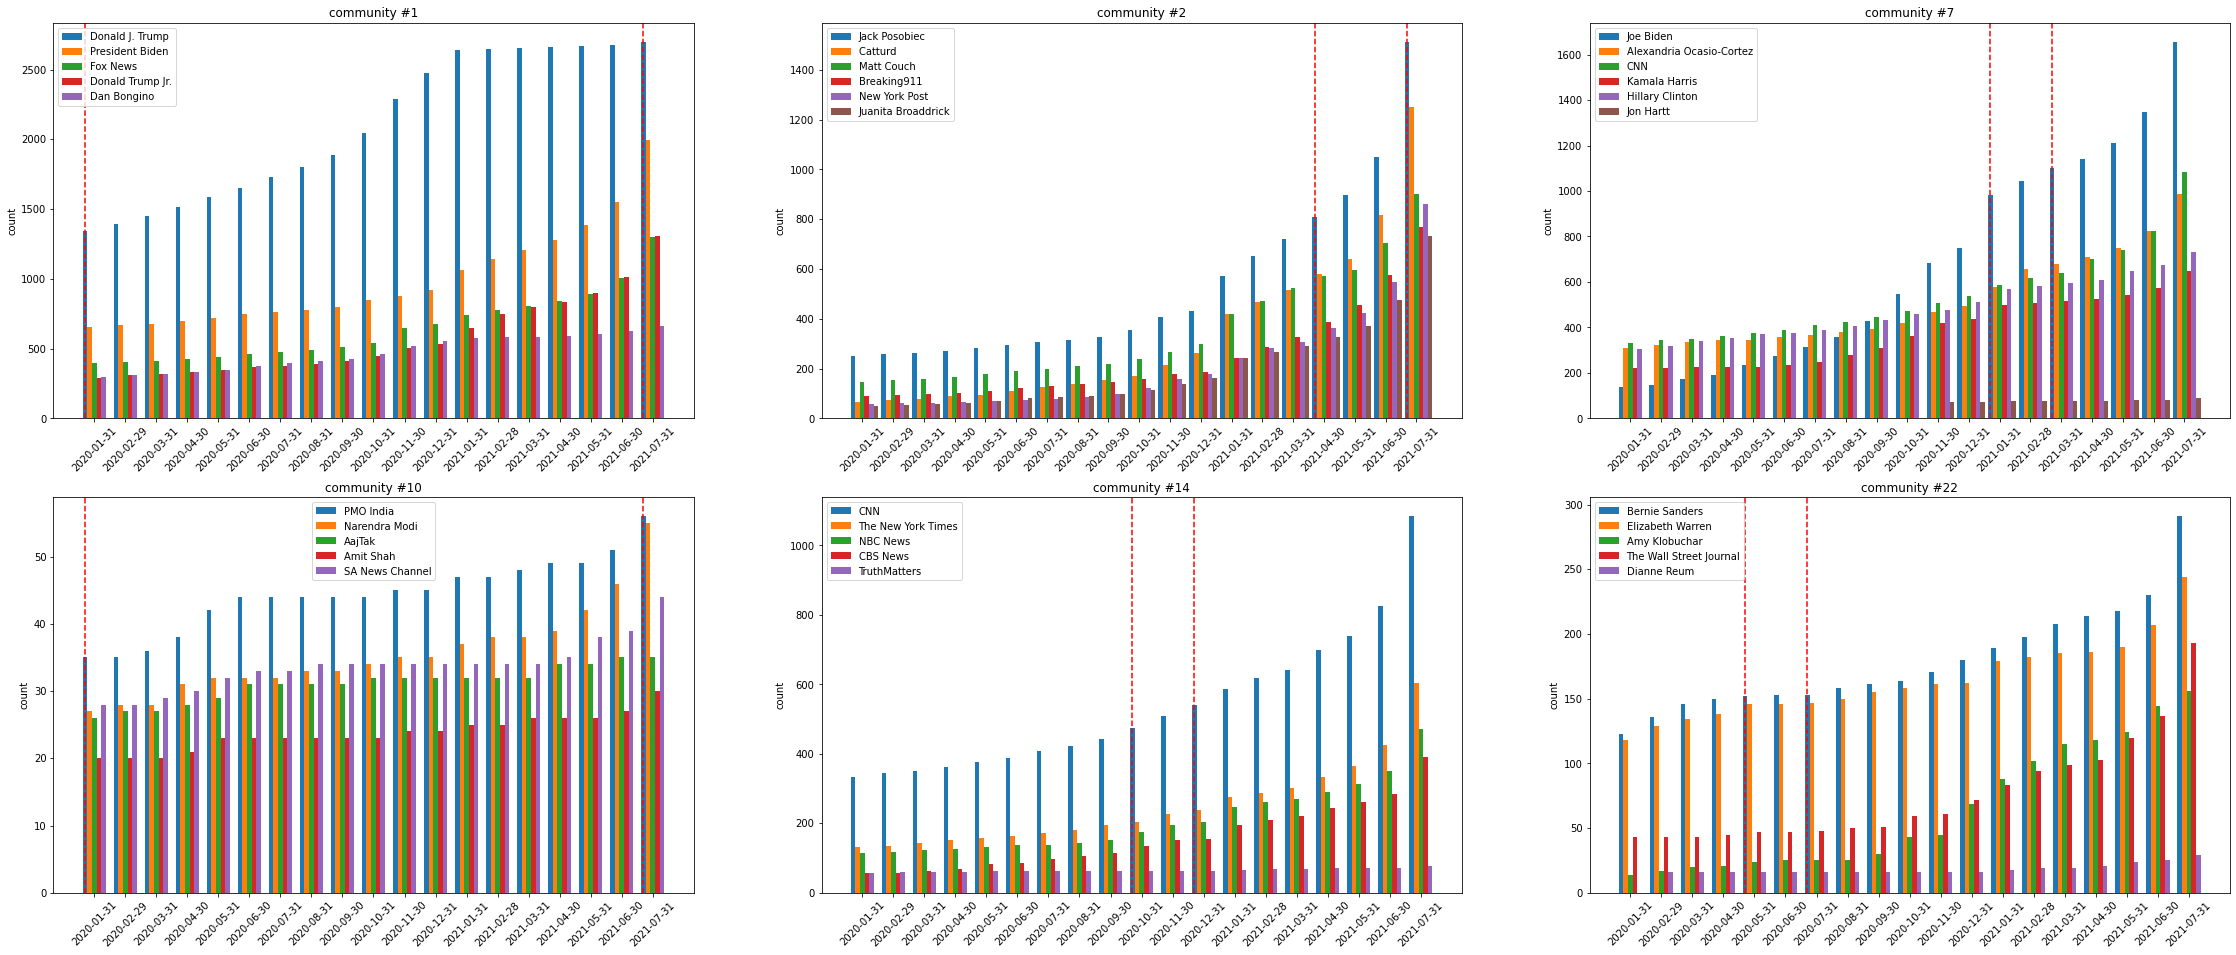

In [ ]:
plt.figure(figsize=(3*13, 2*8))
selected_coms = [1, 2, 7, 10, 14, 22]
count = 0
for t, comm_nodes in enumerate(comm_sorted_users):
  if (t+1) in selected_coms:
  # comm_nodes = comm_sorted_users[0]
    count += 1
    node_prob = dict()
    filtered_time = []
    for comm, nodes in comm_nodes:
      time = int(comm.split('_')[0])
      filtered_time.append(time)
      for node, prob in nodes:
        if node not in node_prob.keys():
          node_prob[node] = [(0, 0)]*len(snapshot_time_points)
        accum_p, times = node_prob[node][time]
        node_prob[node][time] = (prob+accum_p, times+1)


    node_central_score = dict()
    for node in node_prob:
      node_scores = np.zeros(len(snapshot_time_points))
      for i in range(len(snapshot_time_points)):
        if node_prob[node][i][1]:
          node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
        else:
          node_scores[i] = 0
      node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

    sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in sorted_node_prob]
    central_nodes = sorted_nodes[:10]

    plt.subplot(2, 3, count)
    br = np.arange(len(snapshot_time_points))
    for i, central_node in enumerate(central_nodes):
      if int(central_node) in entityid2name:
        prop_interactions = []
        start_time = datetime(2019, 12, 31).strftime('%Y-%m-%d')
        for time, G in enumerate(dynamic_graphs):
          end_time = snapshot_time_points[time].strftime('%Y-%m-%d')
          n_tweets = len(all_tweets_df_time_index.loc[start_time:end_time])
          start_time = end_time
          if central_node in G.nodes():
            current_interactions = len(list(nx.neighbors(G, central_node)))
            prop_interactions.append(current_interactions)
          else:
            prop_interactions.append(0)
        bar_width=0.15
        plt.bar(br, prop_interactions, width=bar_width,  label=entityid2name_ascii[int(central_node)])
        br = [x + bar_width for x in br]
    plt.axvline(x=filtered_time[0], color='r', ls='--')
    plt.axvline(x=filtered_time[-1], color='r', ls='--')
    plt.ylabel('count')
    plt.xticks([r+2*bar_width for r in range(len(snapshot_time_points))],
        [x.strftime('%Y-%m-%d') for x in snapshot_time_points], rotation=45)
    plt.title(f'community #{t+1}')
    plt.legend()


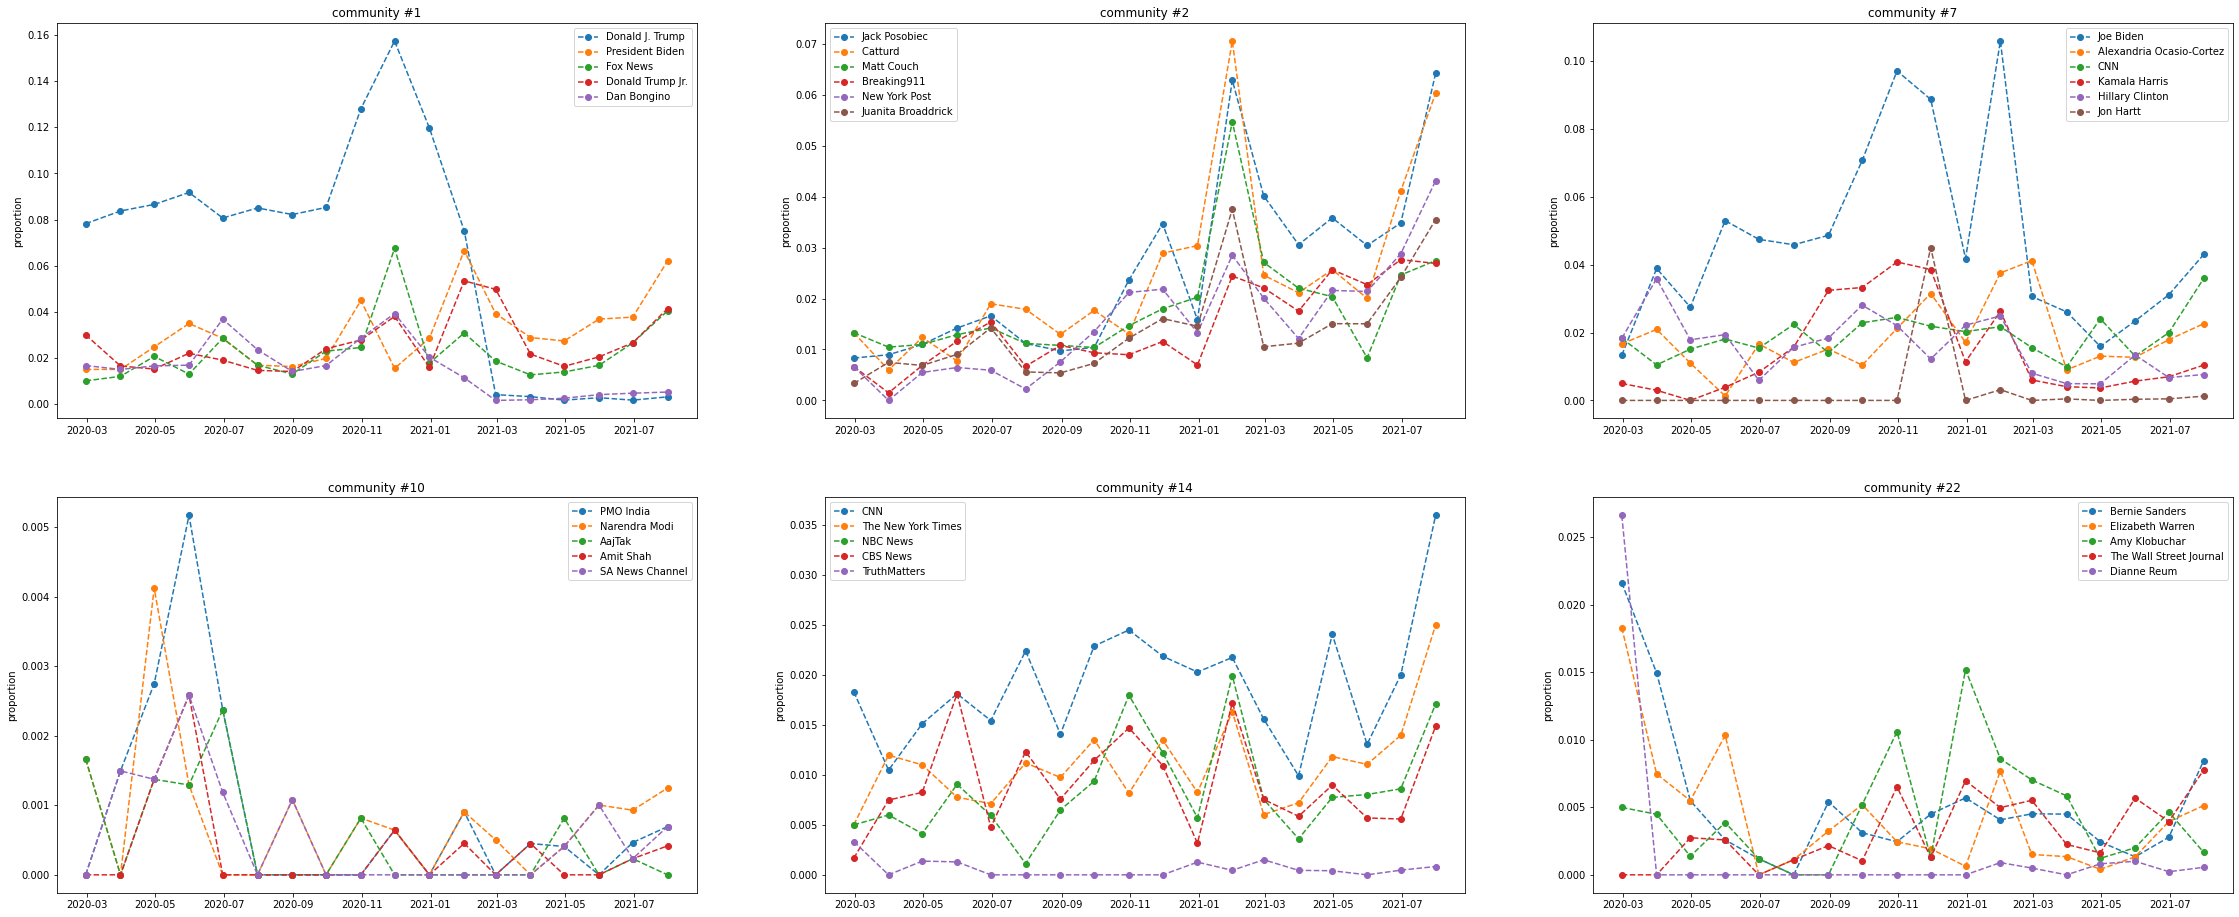

In [ ]:
plt.figure(figsize=(3*13, 2*8))
count = 0
for t, comm_nodes in enumerate(comm_sorted_users):
# comm_nodes = comm_sorted_users[0]
  if t+1 in selected_coms:
    count += 1
    node_prob = dict()

    for comm, nodes in comm_nodes:
      time = int(comm.split('_')[0])
      for node, prob in nodes:
        if node not in node_prob.keys():
          node_prob[node] = [(0, 0)]*len(snapshot_time_points)
        accum_p, times = node_prob[node][time]
        node_prob[node][time] = (prob+accum_p, times+1)


    node_central_score = dict()
    for node in node_prob:
      node_scores = np.zeros(len(snapshot_time_points))
      for i in range(len(snapshot_time_points)):
        if node_prob[node][i][1]:
          node_scores[i] = node_prob[node][i][0] / node_prob[node][i][1]
        else:
          node_scores[i] = 0
      node_central_score[node] = np.sum(node_scores)/len(snapshot_time_points)

    sorted_node_prob = sorted(node_central_score.items(), key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in sorted_node_prob]
    central_nodes = sorted_nodes[:10]

    plt.subplot(2, 3, count)
    for i, central_node in enumerate(central_nodes):
      if int(central_node) in entityid2name:
        prop_interactions = []
        previous_interactions = 0
        start_time = datetime(2019, 12, 31).strftime('%Y-%m-%d')
        for time, G in enumerate(dynamic_graphs):
          end_time = snapshot_time_points[time].strftime('%Y-%m-%d')
          n_users = len(set(all_tweets_df_time_index.loc[start_time:end_time].user_id.values))
          start_time = end_time
          if central_node in G.nodes():
            current_interactions = len(list(nx.neighbors(G, central_node)))
            prop_interactions.append((current_interactions - previous_interactions)/n_users)
            previous_interactions = current_interactions
          else:
            prop_interactions.append(0)
        plt.plot(snapshot_time_points[1:], prop_interactions[1:], '--o', label=entityid2name_ascii[int(central_node)])

    plt.ylabel('proportion')
    plt.title(f'community #{t+1}')
    plt.legend()

In [ ]:
comm_tweets = {}
comm_users = {comm_id: [int(node) for node, _ in nodes] for comm_id, nodes in comm_nodes}
start = datetime(2019, 12, 31).strftime('%Y-%m-%d')
for t in range(len(snapshot_time_points)):
  r = re.compile(f"{t}_*")
  comm_ids = list(filter(r.match, comm_users.keys()))
  end = snapshot_time_points[t].strftime('%Y-%m-%d')
  filtered_tweets = all_tweets_df_time_index.loc[start:end]
  for comm_id in comm_ids:
    comm_user_ids = comm_users[comm_id]
    filtered_tweets_cid = filtered_tweets[filtered_tweets['user_id'].isin(comm_user_ids)]
    print(len(filtered_tweets_cid))
    comm_tweets[comm_id] = filtered_tweets_cid
  start = end

1704
4162
163
3822
191
2579
4202
2339
4179
419
2679
1549
3727
2892
1259
4004
3875
3258
3349
3908
3306
4004
4160
1389
2004
1581
4010
1125
4684
434
183
5627
6662
617
447
8667
7828
1106
724
7382
2591
8739
7080
880
12952
569
13451
20761
7537
16762
984
18586
4291
36501
12895
1318
20132
17707
18992
25586
19814
42093
22050
40142
36557
62903
147405
109198
154859


In [ ]:
for match in matches:
  if match[0] == '7_0' and (match[1] == '8_0' or match[1] == '8_1'):
    print(match)

('7_0', '8_0', 0.8490837965822524)
('7_0', '8_0', 0.8490837965822524)
('7_0', '8_1', 0.40049089793413784)


In [ ]:
print(jaccard(comm_tweets['7_0']['user_id'].values, comm_tweets['8_0']['user_id'].values))
print(jaccard(comm_tweets['7_0']['user_id'].values, comm_tweets['8_1']['user_id'].values))

0.5274853801169591
0.14985590778097982


In [ ]:
print(jaccard(set(comm_users['7_0']).difference(comm_tweets['7_0']['user_id'].values), set(comm_users['8_0']).difference(comm_tweets['8_0']['user_id'].values)))
print(jaccard(set(comm_users['7_0']).difference(comm_tweets['7_0']['user_id'].values), set(comm_users['8_1']).difference(comm_tweets['8_1']['user_id'].values)))

0.8007977475363679
0.4182883939038687
